In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from zipfile import ZipFile

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/train/'

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=10
    num_workers=0
    model_name='resnext50_32x4d'
    size=200
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=40
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    # batch_size=32
    batch_size = 2
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_cols=['label']
    n_fold=4
    trn_fold=[0, 1, 2]
    train=True
    
if CFG.debug:
    CFG.epochs = 1

In [4]:
# ====================================================
# Library
# ====================================================
import sys
# sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
from io import BytesIO
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    # display(y_true)
    # display(y_pred)
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [7]:
folds = {'filename': [], 'label': []}
for filename in os.listdir(TRAIN_PATH + 'yes/'):
  folds['filename'].append(filename)
  folds['label'].append(1)
for filename in os.listdir(TRAIN_PATH + 'no/'):
  folds['filename'].append(filename)
  folds['label'].append(0)

folds = pd.DataFrame(folds)
Fold = StratifiedKFold(n_splits=CFG.n_fold)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['label'])):
  folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())
display(folds)

fold
0    58
1    57
2    56
3    56
dtype: int64

,filename,label,fold
0,Y1.jpg,1,0
1,Y10.jpg,1,0
2,Y100.JPG,1,0
3,Y101.jpg,1,0
4,Y102.jpg,1,0
...,...,...,...
222,No18.jpg,0,3
223,No19.jpg,0,3
224,No20.jpg,0,3
225,No21.jpg,0,3


In [8]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['filename'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = torch.tensor([self.labels[idx]]).float()
        if(label.item() == 1):
          image = cv2.imread(TRAIN_PATH + 'yes/' + file_name)
          # label = np.array([1]).astype(np.float)
        else:
          image = cv2.imread(TRAIN_PATH + 'no/' + file_name)
          # label = np.array([0]).astype(np.float)
          
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [9]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

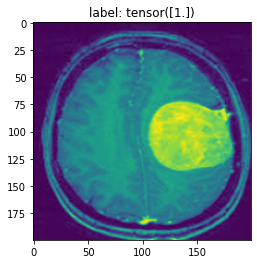

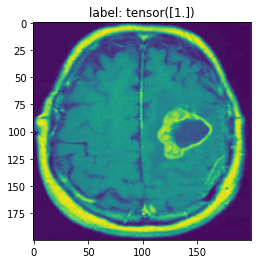

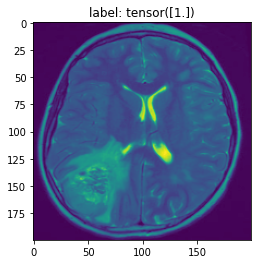

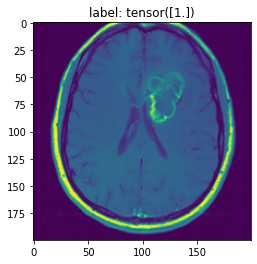

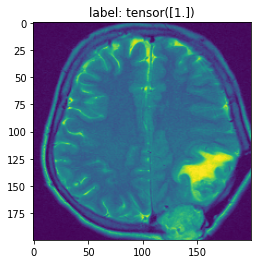

In [10]:
train_dataset = TrainDataset(folds, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [11]:

tst_idx = folds[folds['fold'] == CFG.n_fold - 1].index

test_fold = folds.loc[tst_idx].reset_index(drop=True)
_test_fold = test_fold.copy(deep=True)
test_dataset = TrainDataset(_test_fold, transform=get_transforms(data='valid'))

folds = folds[folds['fold'].isin([i for i in range(CFG.n_fold - 1)])]
display(folds.groupby('fold').size())
display(folds)

fold
0    58
1    57
2    56
dtype: int64

,filename,label,fold
0,Y1.jpg,1,0
1,Y10.jpg,1,0
2,Y100.JPG,1,0
3,Y101.jpg,1,0
4,Y102.jpg,1,0
...,...,...,...
201,no 3.jpg,0,2
202,no 5.jpeg,0,2
203,no 6.jpg,0,2
204,no 7.jpeg,0,2


In [12]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if(pretrained):
          self.model.load_state_dict(torch.load('../models/resnext50_32x4d_a1h-0146ab0a.pth'))
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        # loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [14]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        """
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        """
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    test_loader = DataLoader(test_dataset, 
                        batch_size=CFG.batch_size, 
                        shuffle=False, 
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # test
    test_labels = test_fold[CFG.target_cols].values
    avg_test_loss, preds = valid_fn(test_loader, model, criterion, device)
    score, scores = get_score(test_labels, preds)
    
    LOGGER.info(f"========== fold: {fold} test ==========")
    LOGGER.info(f'test: avg_val_loss: {avg_test_loss:.4f}')
    LOGGER.info(f'test: Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

    return valid_folds

In [15]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold - 1):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                # display(_oof_df)
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [16]:
main()

========== fold: 0 training ==========


Epoch: [1][0/56] Data 0.194 (0.194) Elapsed 0m 2s (remain 1m 56s) Loss: 0.6934(0.6934) Grad: nan  
Epoch: [1][10/56] Data 0.014 (0.034) Elapsed 0m 6s (remain 0m 25s) Loss: 0.6485(0.6842) Grad: 108370.8125  
Epoch: [1][20/56] Data 0.027 (0.027) Elapsed 0m 11s (remain 0m 18s) Loss: 0.6698(0.6749) Grad: 136042.0938  
Epoch: [1][30/56] Data 0.013 (0.024) Elapsed 0m 15s (remain 0m 12s) Loss: 0.5733(0.6796) Grad: 64778.1133  
Epoch: [1][40/56] Data 0.014 (0.023) Elapsed 0m 21s (remain 0m 7s) Loss: 0.5433(0.6612) Grad: 38959.5195  
Epoch: [1][50/56] Data 0.013 (0.021) Elapsed 0m 25s (remain 0m 2s) Loss: 0.6368(0.6609) Grad: 131064.4453  
Epoch: [1][55/56] Data 0.013 (0.022) Elapsed 0m 28s (remain 0m 0s) Loss: 0.6989(0.6665) Grad: 133534.8438  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2474(0.2474) 
EVAL: [10/15] Data 0.028 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8849(0.3942) 
EVAL: [14/15] Data 0.019 (0.033) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9233(0.6182) 


Epoch 1 - avg_train_loss: 0.6665  avg_val_loss: 0.6182  time: 31s
Epoch 1 - Score: 0.8586  Scores: [0.8586]
Epoch 1 - Save Best Loss: 0.6182 Model


Epoch: [2][0/56] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 25s) Loss: 0.4616(0.4616) Grad: nan  
Epoch: [2][10/56] Data 0.017 (0.017) Elapsed 0m 5s (remain 0m 22s) Loss: 0.4591(0.5620) Grad: 56408.2344  
Epoch: [2][20/56] Data 0.015 (0.017) Elapsed 0m 10s (remain 0m 17s) Loss: 1.0886(0.6281) Grad: 169850.2188  
Epoch: [2][30/56] Data 0.016 (0.017) Elapsed 0m 16s (remain 0m 12s) Loss: 0.4136(0.6269) Grad: 37699.9375  
Epoch: [2][40/56] Data 0.015 (0.017) Elapsed 0m 21s (remain 0m 7s) Loss: 0.4042(0.6507) Grad: 19254.8047  
Epoch: [2][50/56] Data 0.011 (0.017) Elapsed 0m 27s (remain 0m 2s) Loss: 1.0809(0.6701) Grad: 74513.6016  
Epoch: [2][55/56] Data 0.013 (0.017) Elapsed 0m 30s (remain 0m 0s) Loss: 0.3488(0.6482) Grad: 8421.6992  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 1s) Loss: 0.3537(0.3537) 
EVAL: [10/15] Data 0.034 (0.040) Elapsed 0m 1s (remain 0m 0s) Loss: 1.0422(0.4757) 
EVAL: [14/15] Data 0.013 (0.038) Elapsed 0m 2s (remain 0m 0s) Loss: 1.2509(0.6185) 


Epoch 2 - avg_train_loss: 0.6482  avg_val_loss: 0.6185  time: 33s
Epoch 2 - Score: 0.8182  Scores: [0.8182]


Epoch: [3][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 25s) Loss: 1.1478(1.1478) Grad: nan  
Epoch: [3][10/56] Data 0.022 (0.016) Elapsed 0m 6s (remain 0m 25s) Loss: 0.6372(0.6182) Grad: 76531.4922  
Epoch: [3][20/56] Data 0.016 (0.018) Elapsed 0m 12s (remain 0m 20s) Loss: 1.3940(0.6983) Grad: 89159.8750  
Epoch: [3][30/56] Data 0.011 (0.017) Elapsed 0m 18s (remain 0m 14s) Loss: 0.2649(0.6676) Grad: 36134.4648  
Epoch: [3][40/56] Data 0.013 (0.018) Elapsed 0m 24s (remain 0m 8s) Loss: 0.7434(0.6863) Grad: 131883.9375  
Epoch: [3][50/56] Data 0.012 (0.017) Elapsed 0m 30s (remain 0m 2s) Loss: 0.2684(0.6539) Grad: 25420.5293  
Epoch: [3][55/56] Data 0.012 (0.017) Elapsed 0m 33s (remain 0m 0s) Loss: 1.1478(0.6401) Grad: 248659.4531  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2854(0.2854) 
EVAL: [10/15] Data 0.032 (0.038) Elapsed 0m 1s (remain 0m 0s) Loss: 1.1937(0.4301) 
EVAL: [14/15] Data 0.022 (0.037) Elapsed 0m 2s (remain 0m 0s) Loss: 1.3931(0.6042) 


Epoch 3 - avg_train_loss: 0.6401  avg_val_loss: 0.6042  time: 36s
Epoch 3 - Score: 0.8359  Scores: [0.8359]
Epoch 3 - Save Best Loss: 0.6042 Model


Epoch: [4][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 27s) Loss: 0.2453(0.2453) Grad: 724920.5625  
Epoch: [4][10/56] Data 0.011 (0.017) Elapsed 0m 6s (remain 0m 28s) Loss: 0.7126(0.4894) Grad: 183122.5625  
Epoch: [4][20/56] Data 0.015 (0.016) Elapsed 0m 12s (remain 0m 21s) Loss: 0.5586(0.5173) Grad: 91349.7344  
Epoch: [4][30/56] Data 0.011 (0.016) Elapsed 0m 19s (remain 0m 15s) Loss: 0.8876(0.5188) Grad: 163774.2969  
Epoch: [4][40/56] Data 0.015 (0.016) Elapsed 0m 25s (remain 0m 9s) Loss: 1.4283(0.6072) Grad: 76271.6797  
Epoch: [4][50/56] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 3s) Loss: 0.4754(0.5952) Grad: 19955.0605  
Epoch: [4][55/56] Data 0.015 (0.017) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4374(0.6019) Grad: 19624.8125  
EVAL: [0/15] Data 0.037 (0.037) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2489(0.2489) 
EVAL: [10/15] Data 0.035 (0.046) Elapsed 0m 2s (remain 0m 0s) Loss: 1.2288(0.4062) 
EVAL: [14/15] Data 0.023 (0.044) Elapsed 0m 3s (remain 0m 0s) Loss: 1.3789(0.581

Epoch 4 - avg_train_loss: 0.6019  avg_val_loss: 0.5816  time: 38s
Epoch 4 - Score: 0.8434  Scores: [0.8434]
Epoch 4 - Save Best Loss: 0.5816 Model


Epoch: [5][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 39s) Loss: 0.2105(0.2105) Grad: inf  
Epoch: [5][10/56] Data 0.018 (0.019) Elapsed 0m 7s (remain 0m 32s) Loss: 0.2078(0.5594) Grad: 46505.4648  
Epoch: [5][20/56] Data 0.025 (0.049) Elapsed 0m 17s (remain 0m 29s) Loss: 0.2222(0.5684) Grad: 53235.9258  
Epoch: [5][30/56] Data 0.012 (0.038) Elapsed 0m 24s (remain 0m 19s) Loss: 0.4287(0.5812) Grad: 72690.8672  
Epoch: [5][40/56] Data 0.012 (0.034) Elapsed 0m 31s (remain 0m 11s) Loss: 1.6691(0.6087) Grad: 137050.0469  
Epoch: [5][50/56] Data 0.012 (0.031) Elapsed 0m 38s (remain 0m 3s) Loss: 0.1803(0.5924) Grad: 32260.9570  
Epoch: [5][55/56] Data 0.011 (0.030) Elapsed 0m 41s (remain 0m 0s) Loss: 0.5794(0.5712) Grad: 110587.9609  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3400(0.3400) 
EVAL: [10/15] Data 0.026 (0.032) Elapsed 0m 2s (remain 0m 0s) Loss: 1.1109(0.3995) 
EVAL: [14/15] Data 0.032 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 1.4940(0.5622) 


Epoch 5 - avg_train_loss: 0.5712  avg_val_loss: 0.5622  time: 45s
Epoch 5 - Score: 0.8801  Scores: [0.8801]
Epoch 5 - Save Best Loss: 0.5622 Model


Epoch: [6][0/56] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 25s) Loss: 1.4923(1.4923) Grad: nan  
Epoch: [6][10/56] Data 0.024 (0.019) Elapsed 0m 7s (remain 0m 31s) Loss: 1.6587(0.6291) Grad: 440509.8438  
Epoch: [6][20/56] Data 0.010 (0.017) Elapsed 0m 14s (remain 0m 23s) Loss: 0.5482(0.6202) Grad: 128134.0469  
Epoch: [6][30/56] Data 0.010 (0.017) Elapsed 0m 20s (remain 0m 16s) Loss: 0.5078(0.5801) Grad: 165754.4844  
Epoch: [6][40/56] Data 0.011 (0.018) Elapsed 0m 27s (remain 0m 10s) Loss: 1.5832(0.5928) Grad: 208375.8281  
Epoch: [6][50/56] Data 0.013 (0.020) Elapsed 0m 35s (remain 0m 3s) Loss: 0.2303(0.5539) Grad: 40460.2578  
Epoch: [6][55/56] Data 0.016 (0.020) Elapsed 0m 38s (remain 0m 0s) Loss: 1.6668(0.5626) Grad: 199681.5312  
EVAL: [0/15] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2322(0.2322) 
EVAL: [10/15] Data 0.035 (0.037) Elapsed 0m 2s (remain 0m 0s) Loss: 1.3118(0.3971) 
EVAL: [14/15] Data 0.015 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 1.8408(0.5885) 


Epoch 6 - avg_train_loss: 0.5626  avg_val_loss: 0.5885  time: 42s
Epoch 6 - Score: 0.8460  Scores: [0.846]


Epoch: [7][0/56] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 26s) Loss: 0.4764(0.4764) Grad: inf  
Epoch: [7][10/56] Data 0.015 (0.014) Elapsed 0m 7s (remain 0m 31s) Loss: 0.5328(0.4375) Grad: inf  
Epoch: [7][20/56] Data 0.010 (0.013) Elapsed 0m 14s (remain 0m 24s) Loss: 0.4043(0.4237) Grad: 52291.7500  
Epoch: [7][30/56] Data 0.011 (0.014) Elapsed 0m 21s (remain 0m 17s) Loss: 0.2684(0.4546) Grad: 32812.9961  
Epoch: [7][40/56] Data 0.014 (0.014) Elapsed 0m 28s (remain 0m 10s) Loss: 0.2336(0.4731) Grad: 38196.1602  
Epoch: [7][50/56] Data 0.011 (0.015) Elapsed 0m 34s (remain 0m 3s) Loss: 1.3412(0.5391) Grad: 195292.4062  
Epoch: [7][55/56] Data 0.016 (0.015) Elapsed 0m 38s (remain 0m 0s) Loss: 0.6001(0.5388) Grad: 100319.8906  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2291(0.2291) 
EVAL: [10/15] Data 0.028 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 1.2309(0.3710) 
EVAL: [14/15] Data 0.020 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.7976(0.5783) 


Epoch 7 - avg_train_loss: 0.5388  avg_val_loss: 0.5783  time: 42s
Epoch 7 - Score: 0.8548  Scores: [0.8548]


Epoch: [8][0/56] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 33s) Loss: 0.2168(0.2168) Grad: inf  
Epoch: [8][10/56] Data 0.011 (0.014) Elapsed 0m 7s (remain 0m 29s) Loss: 0.1593(0.3069) Grad: 62077.3633  
Epoch: [8][20/56] Data 0.012 (0.015) Elapsed 0m 13s (remain 0m 23s) Loss: 0.4783(0.3932) Grad: 208863.2500  
Epoch: [8][30/56] Data 0.014 (0.015) Elapsed 0m 20s (remain 0m 16s) Loss: 1.8293(0.4880) Grad: 107444.9766  
Epoch: [8][40/56] Data 0.012 (0.015) Elapsed 0m 27s (remain 0m 10s) Loss: 0.7279(0.5077) Grad: 173390.6562  
Epoch: [8][50/56] Data 0.011 (0.016) Elapsed 0m 34s (remain 0m 3s) Loss: 1.5417(0.5374) Grad: 132055.4375  
Epoch: [8][55/56] Data 0.012 (0.016) Elapsed 0m 37s (remain 0m 0s) Loss: 0.6271(0.5284) Grad: 128896.4297  
EVAL: [0/15] Data 0.032 (0.032) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2513(0.2513) 
EVAL: [10/15] Data 0.024 (0.033) Elapsed 0m 2s (remain 0m 1s) Loss: 1.2219(0.3939) 
EVAL: [14/15] Data 0.016 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.5279(0.5690) 


Epoch 8 - avg_train_loss: 0.5284  avg_val_loss: 0.5690  time: 41s
Epoch 8 - Score: 0.8573  Scores: [0.8573]


Epoch: [9][0/56] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 43s) Loss: 0.4827(0.4827) Grad: nan  
Epoch: [9][10/56] Data 0.011 (0.014) Elapsed 0m 7s (remain 0m 30s) Loss: 0.5577(0.3748) Grad: inf  
Epoch: [9][20/56] Data 0.015 (0.013) Elapsed 0m 13s (remain 0m 22s) Loss: 0.4383(0.3989) Grad: 63509.1758  
Epoch: [9][30/56] Data 0.015 (0.015) Elapsed 0m 20s (remain 0m 16s) Loss: 0.2197(0.4695) Grad: 126526.5703  
Epoch: [9][40/56] Data 0.012 (0.015) Elapsed 0m 26s (remain 0m 9s) Loss: 1.6804(0.5614) Grad: 114759.6797  
Epoch: [9][50/56] Data 0.013 (0.015) Elapsed 0m 32s (remain 0m 3s) Loss: 0.1708(0.5468) Grad: 13214.0156  
Epoch: [9][55/56] Data 0.017 (0.016) Elapsed 0m 35s (remain 0m 0s) Loss: 1.3846(0.5496) Grad: 297362.2500  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2265(0.2265) 
EVAL: [10/15] Data 0.030 (0.036) Elapsed 0m 2s (remain 0m 0s) Loss: 1.2529(0.3743) 
EVAL: [14/15] Data 0.017 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 1.6781(0.5667) 


Epoch 9 - avg_train_loss: 0.5496  avg_val_loss: 0.5667  time: 39s
Epoch 9 - Score: 0.8561  Scores: [0.8561]


Epoch: [10][0/56] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 31s) Loss: 0.2271(0.2271) Grad: inf  
Epoch: [10][10/56] Data 0.020 (0.014) Elapsed 0m 7s (remain 0m 31s) Loss: 0.5029(0.5705) Grad: 176416.7500  
Epoch: [10][20/56] Data 0.012 (0.015) Elapsed 0m 15s (remain 0m 25s) Loss: 0.2254(0.5975) Grad: 192164.9062  
Epoch: [10][30/56] Data 0.011 (0.015) Elapsed 0m 22s (remain 0m 18s) Loss: 0.1511(0.5337) Grad: 34144.2930  
Epoch: [10][40/56] Data 0.019 (0.016) Elapsed 0m 29s (remain 0m 10s) Loss: 0.5152(0.5234) Grad: 286382.0938  
Epoch: [10][50/56] Data 0.016 (0.016) Elapsed 0m 36s (remain 0m 3s) Loss: 0.3406(0.5324) Grad: 46270.5039  
Epoch: [10][55/56] Data 0.019 (0.017) Elapsed 0m 40s (remain 0m 0s) Loss: 0.4714(0.5254) Grad: 149465.1875  
EVAL: [0/15] Data 0.032 (0.032) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1852(0.1852) 
EVAL: [10/15] Data 0.023 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 1.2523(0.3815) 
EVAL: [14/15] Data 0.025 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 1.6984(0.5

Epoch 10 - avg_train_loss: 0.5254  avg_val_loss: 0.5550  time: 44s
Epoch 10 - Score: 0.8460  Scores: [0.846]
Epoch 10 - Save Best Loss: 0.5550 Model


Epoch: [11][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 26s) Loss: 0.5092(0.5092) Grad: inf  
Epoch: [11][10/56] Data 0.010 (0.016) Elapsed 0m 8s (remain 0m 35s) Loss: 1.7334(0.5043) Grad: inf  
Epoch: [11][20/56] Data 0.015 (0.015) Elapsed 0m 15s (remain 0m 25s) Loss: 0.8125(0.4860) Grad: 375283.8438  
Epoch: [11][30/56] Data 0.016 (0.016) Elapsed 0m 21s (remain 0m 17s) Loss: 0.2669(0.5207) Grad: 47858.6250  
Epoch: [11][40/56] Data 0.012 (0.015) Elapsed 0m 28s (remain 0m 10s) Loss: 0.1849(0.4939) Grad: 28073.6914  
Epoch: [11][50/56] Data 0.012 (0.015) Elapsed 0m 34s (remain 0m 3s) Loss: 0.1149(0.4783) Grad: 9355.1641  
Epoch: [11][55/56] Data 0.012 (0.016) Elapsed 0m 37s (remain 0m 0s) Loss: 0.5498(0.4624) Grad: 90104.2656  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3782(0.3782) 
EVAL: [10/15] Data 0.025 (0.030) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8458(0.3661) 
EVAL: [14/15] Data 0.018 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 1.3300(0.4624) 


Epoch 11 - avg_train_loss: 0.4624  avg_val_loss: 0.4624  time: 42s
Epoch 11 - Score: 0.8939  Scores: [0.8939]
Epoch 11 - Save Best Loss: 0.4624 Model


Epoch: [12][0/56] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 34s) Loss: 0.2752(0.2752) Grad: inf  
Epoch: [12][10/56] Data 0.011 (0.014) Elapsed 0m 7s (remain 0m 29s) Loss: 0.1196(0.3661) Grad: 61027.0039  
Epoch: [12][20/56] Data 0.012 (0.015) Elapsed 0m 13s (remain 0m 23s) Loss: 0.2420(0.5281) Grad: 216743.7031  
Epoch: [12][30/56] Data 0.019 (0.015) Elapsed 0m 20s (remain 0m 16s) Loss: 0.0951(0.4814) Grad: 26880.7500  
Epoch: [12][40/56] Data 0.012 (0.015) Elapsed 0m 27s (remain 0m 9s) Loss: 0.1825(0.5444) Grad: 8937.6006  
Epoch: [12][50/56] Data 0.011 (0.015) Elapsed 0m 33s (remain 0m 3s) Loss: 0.1856(0.4753) Grad: 29684.4316  
Epoch: [12][55/56] Data 0.013 (0.016) Elapsed 0m 37s (remain 0m 0s) Loss: 0.1992(0.4514) Grad: 23388.8555  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2162(0.2162) 
EVAL: [10/15] Data 0.026 (0.028) Elapsed 0m 2s (remain 0m 1s) Loss: 1.0972(0.2850) 
EVAL: [14/15] Data 0.015 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 1.5179(0.3740) 

Epoch 12 - avg_train_loss: 0.4514  avg_val_loss: 0.3740  time: 41s
Epoch 12 - Score: 0.9129  Scores: [0.9129]
Epoch 12 - Save Best Loss: 0.3740 Model


Epoch: [13][0/56] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 29s) Loss: 0.1214(0.1214) Grad: 235819.1094  
Epoch: [13][10/56] Data 0.012 (0.016) Elapsed 0m 9s (remain 0m 37s) Loss: 0.2810(0.5699) Grad: inf  
Epoch: [13][20/56] Data 0.018 (0.015) Elapsed 0m 15s (remain 0m 26s) Loss: 0.1959(0.4611) Grad: 66459.9375  
Epoch: [13][30/56] Data 0.011 (0.016) Elapsed 0m 23s (remain 0m 18s) Loss: 0.2756(0.5140) Grad: 150956.8281  
Epoch: [13][40/56] Data 0.011 (0.016) Elapsed 0m 29s (remain 0m 10s) Loss: 0.0648(0.4430) Grad: 7823.9590  
Epoch: [13][50/56] Data 0.011 (0.016) Elapsed 0m 36s (remain 0m 3s) Loss: 0.1565(0.4312) Grad: 60436.7852  
Epoch: [13][55/56] Data 0.014 (0.016) Elapsed 0m 39s (remain 0m 0s) Loss: 2.1574(0.4833) Grad: 270111.3125  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0801(0.0801) 
EVAL: [10/15] Data 0.028 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0356(0.2913) 
EVAL: [14/15] Data 0.019 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 1.2485(0.372

Epoch 13 - avg_train_loss: 0.4833  avg_val_loss: 0.3729  time: 43s
Epoch 13 - Score: 0.8851  Scores: [0.8851]
Epoch 13 - Save Best Loss: 0.3729 Model


Epoch: [14][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 28s) Loss: 0.0306(0.0306) Grad: 105407.9375  
Epoch: [14][10/56] Data 0.018 (0.021) Elapsed 0m 8s (remain 0m 33s) Loss: 0.1877(0.4284) Grad: 478596.8125  
Epoch: [14][20/56] Data 0.014 (0.022) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0324(0.3430) Grad: 7602.5615  
Epoch: [14][30/56] Data 0.011 (0.020) Elapsed 0m 22s (remain 0m 17s) Loss: 0.0417(0.4642) Grad: 11445.9414  
Epoch: [14][40/56] Data 0.011 (0.019) Elapsed 0m 28s (remain 0m 10s) Loss: 0.0239(0.4283) Grad: 2488.9299  
Epoch: [14][50/56] Data 0.011 (0.019) Elapsed 0m 36s (remain 0m 3s) Loss: 1.4355(0.4308) Grad: 91265.7969  
Epoch: [14][55/56] Data 0.013 (0.019) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0097(0.4426) Grad: 515.5192  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1325(0.1325) 
EVAL: [10/15] Data 0.032 (0.030) Elapsed 0m 2s (remain 0m 1s) Loss: 0.6090(0.2596) 
EVAL: [14/15] Data 0.026 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 1.7333(0.

Epoch 14 - avg_train_loss: 0.4426  avg_val_loss: 0.3734  time: 45s
Epoch 14 - Score: 0.9015  Scores: [0.9015]


Epoch: [15][0/56] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 44s) Loss: 0.4247(0.4247) Grad: nan  
Epoch: [15][10/56] Data 0.012 (0.015) Elapsed 0m 8s (remain 0m 35s) Loss: 0.6689(0.2337) Grad: 572625.6875  
Epoch: [15][20/56] Data 0.017 (0.019) Elapsed 0m 16s (remain 0m 27s) Loss: 1.8899(0.2951) Grad: 639715.0000  
Epoch: [15][30/56] Data 0.011 (0.018) Elapsed 0m 23s (remain 0m 18s) Loss: 0.0155(0.3114) Grad: 2890.3469  
Epoch: [15][40/56] Data 0.014 (0.018) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0074(0.2772) Grad: 1083.0573  
Epoch: [15][50/56] Data 0.010 (0.018) Elapsed 0m 37s (remain 0m 3s) Loss: 0.0055(0.2436) Grad: 1009.1759  
Epoch: [15][55/56] Data 0.013 (0.018) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0038(0.2518) Grad: 355.4193  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2488(0.2488) 
EVAL: [10/15] Data 0.052 (0.033) Elapsed 0m 2s (remain 0m 1s) Loss: 0.2568(0.2939) 
EVAL: [14/15] Data 0.018 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.5449(0.3191) 


Epoch 15 - avg_train_loss: 0.2518  avg_val_loss: 0.3191  time: 45s
Epoch 15 - Score: 0.9331  Scores: [0.9331]
Epoch 15 - Save Best Loss: 0.3191 Model


Epoch: [16][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 29s) Loss: 0.0030(0.0030) Grad: 5632.8726  
Epoch: [16][10/56] Data 0.010 (0.015) Elapsed 0m 8s (remain 0m 35s) Loss: 0.4574(0.2866) Grad: inf  
Epoch: [16][20/56] Data 0.011 (0.014) Elapsed 0m 15s (remain 0m 25s) Loss: 0.0023(0.4583) Grad: 202.3307  
Epoch: [16][30/56] Data 0.013 (0.015) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0028(0.3636) Grad: 244.0519  
Epoch: [16][40/56] Data 0.013 (0.015) Elapsed 0m 28s (remain 0m 10s) Loss: 0.0028(0.4246) Grad: 226.6876  
Epoch: [16][50/56] Data 0.011 (0.015) Elapsed 0m 35s (remain 0m 3s) Loss: 0.7439(0.4212) Grad: 505657.4062  
Epoch: [16][55/56] Data 0.013 (0.016) Elapsed 0m 38s (remain 0m 0s) Loss: 0.3904(0.4219) Grad: 217108.3125  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2043(0.2043) 
EVAL: [10/15] Data 0.029 (0.037) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2664(0.3271) 
EVAL: [14/15] Data 0.021 (0.036) Elapsed 0m 3s (remain 0m 0s) Loss: 1.3311(0.3341) 


Epoch 16 - avg_train_loss: 0.4219  avg_val_loss: 0.3341  time: 42s
Epoch 16 - Score: 0.9369  Scores: [0.9369]


Epoch: [17][0/56] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0983(0.0983) Grad: inf  
Epoch: [17][10/56] Data 0.014 (0.014) Elapsed 0m 7s (remain 0m 28s) Loss: 0.0099(0.2221) Grad: 13423.9512  
Epoch: [17][20/56] Data 0.011 (0.015) Elapsed 0m 13s (remain 0m 22s) Loss: 0.0039(0.2366) Grad: 1073.8622  
Epoch: [17][30/56] Data 0.012 (0.015) Elapsed 0m 20s (remain 0m 16s) Loss: 0.0166(0.3025) Grad: 2791.6233  
Epoch: [17][40/56] Data 0.013 (0.015) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0175(0.3000) Grad: 2438.1045  
Epoch: [17][50/56] Data 0.010 (0.015) Elapsed 0m 35s (remain 0m 3s) Loss: 0.0015(0.2659) Grad: 105.2811  
Epoch: [17][55/56] Data 0.014 (0.016) Elapsed 0m 38s (remain 0m 0s) Loss: 2.2134(0.3497) Grad: 132753.1250  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1806(0.1806) 
EVAL: [10/15] Data 0.032 (0.032) Elapsed 0m 2s (remain 0m 1s) Loss: 0.3414(0.2560) 
EVAL: [14/15] Data 0.013 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 1.1859(0.2986) 


Epoch 17 - avg_train_loss: 0.3497  avg_val_loss: 0.2986  time: 43s
Epoch 17 - Score: 0.9457  Scores: [0.9457]
Epoch 17 - Save Best Loss: 0.2986 Model


Epoch: [18][0/56] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 29s) Loss: 0.0020(0.0020) Grad: 7747.1064  
Epoch: [18][10/56] Data 0.010 (0.019) Elapsed 0m 8s (remain 0m 33s) Loss: 1.8329(0.6346) Grad: nan  
Epoch: [18][20/56] Data 0.013 (0.016) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0190(0.3982) Grad: 6037.8384  
Epoch: [18][30/56] Data 0.014 (0.016) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0596(0.2767) Grad: 55112.1953  
Epoch: [18][40/56] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 11s) Loss: 0.0063(0.3217) Grad: 1550.3647  
Epoch: [18][50/56] Data 0.011 (0.016) Elapsed 0m 39s (remain 0m 3s) Loss: 0.1429(0.3159) Grad: 154409.8906  
Epoch: [18][55/56] Data 0.011 (0.016) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0140(0.2929) Grad: 5765.0293  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4018(0.4018) 
EVAL: [10/15] Data 0.032 (0.041) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2481(0.4432) 
EVAL: [14/15] Data 0.016 (0.038) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0879(0.4118) 


Epoch 18 - avg_train_loss: 0.2929  avg_val_loss: 0.4118  time: 47s
Epoch 18 - Score: 0.9255  Scores: [0.9255]


Epoch: [19][0/56] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0134(0.0134) Grad: 51677.0820  
Epoch: [19][10/56] Data 0.013 (0.018) Elapsed 0m 7s (remain 0m 28s) Loss: 0.0015(0.3971) Grad: 626.2676  
Epoch: [19][20/56] Data 0.010 (0.017) Elapsed 0m 13s (remain 0m 22s) Loss: 0.0027(0.3878) Grad: 700.0313  
Epoch: [19][30/56] Data 0.014 (0.017) Elapsed 0m 19s (remain 0m 16s) Loss: 0.0022(0.3420) Grad: 383.2534  
Epoch: [19][40/56] Data 0.013 (0.017) Elapsed 0m 26s (remain 0m 9s) Loss: 0.0160(0.2605) Grad: 2027.7961  
Epoch: [19][50/56] Data 0.014 (0.017) Elapsed 0m 34s (remain 0m 3s) Loss: 0.0012(0.2368) Grad: 89.0087  
Epoch: [19][55/56] Data 0.023 (0.018) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0115(0.2161) Grad: 1513.3054  
EVAL: [0/15] Data 0.048 (0.048) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2431(0.2431) 
EVAL: [10/15] Data 0.044 (0.058) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3105(0.2883) 
EVAL: [14/15] Data 0.020 (0.052) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9554(0.3137) 


Epoch 19 - avg_train_loss: 0.2161  avg_val_loss: 0.3137  time: 42s
Epoch 19 - Score: 0.9369  Scores: [0.9369]


Epoch: [20][0/56] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0020(0.0020) Grad: 7738.3330  
Epoch: [20][10/56] Data 0.014 (0.020) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0038(0.1661) Grad: 7375.3530  
Epoch: [20][20/56] Data 0.016 (0.020) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0243(0.2544) Grad: 50202.3906  
Epoch: [20][30/56] Data 0.013 (0.020) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0014(0.3526) Grad: 58.0621  
Epoch: [20][40/56] Data 0.013 (0.019) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0027(0.3392) Grad: 492.2317  
Epoch: [20][50/56] Data 0.014 (0.020) Elapsed 0m 40s (remain 0m 3s) Loss: 0.0340(0.2992) Grad: 11340.2881  
Epoch: [20][55/56] Data 0.027 (0.020) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0359(0.3131) Grad: 7874.3936  
EVAL: [0/15] Data 0.034 (0.034) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1036(0.1036) 
EVAL: [10/15] Data 0.052 (0.061) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2878(0.2262) 
EVAL: [14/15] Data 0.021 (0.055) Elapsed 0m 3s (remain 0m 0s) Loss: 1.1717(0.2779) 

Epoch 20 - avg_train_loss: 0.3131  avg_val_loss: 0.2779  time: 48s
Epoch 20 - Score: 0.9558  Scores: [0.9558]
Epoch 20 - Save Best Loss: 0.2779 Model


Epoch: [21][0/56] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0261(0.0261) Grad: 439341.7188  
Epoch: [21][10/56] Data 0.012 (0.030) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0091(0.5286) Grad: 14487.4268  
Epoch: [21][20/56] Data 0.016 (0.029) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0016(0.4334) Grad: 709.1407  
Epoch: [21][30/56] Data 0.015 (0.025) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0095(0.4163) Grad: 2790.7722  
Epoch: [21][40/56] Data 0.034 (0.025) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0117(0.3379) Grad: 5265.1235  
Epoch: [21][50/56] Data 0.041 (0.026) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0102(0.2726) Grad: 2008.1765  
Epoch: [21][55/56] Data 0.016 (0.026) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0077(0.3098) Grad: 943.0583  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6494(0.6494) 
EVAL: [10/15] Data 0.024 (0.041) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2574(0.4422) 
EVAL: [14/15] Data 0.015 (0.038) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8683(0.4091

Epoch 21 - avg_train_loss: 0.3098  avg_val_loss: 0.4091  time: 50s
Epoch 21 - Score: 0.9419  Scores: [0.9419]


Epoch: [22][0/56] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 48s) Loss: 0.0010(0.0010) Grad: 2747.3618  
Epoch: [22][10/56] Data 0.027 (0.028) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0019(0.0456) Grad: 2452.2708  
Epoch: [22][20/56] Data 0.055 (0.030) Elapsed 0m 17s (remain 0m 28s) Loss: 0.0070(0.4172) Grad: 3212.1973  
Epoch: [22][30/56] Data 0.037 (0.037) Elapsed 0m 26s (remain 0m 21s) Loss: 1.9835(0.3742) Grad: 338410.1875  
Epoch: [22][40/56] Data 0.035 (0.037) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0549(0.3567) Grad: 56959.1250  
Epoch: [22][50/56] Data 0.015 (0.034) Elapsed 0m 40s (remain 0m 3s) Loss: 0.0071(0.3248) Grad: 4730.0322  
Epoch: [22][55/56] Data 0.010 (0.033) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0199(0.2983) Grad: 18031.0762  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0890(0.0890) 
EVAL: [10/15] Data 0.056 (0.042) Elapsed 0m 2s (remain 0m 1s) Loss: 0.2750(0.3045) 
EVAL: [14/15] Data 0.025 (0.050) Elapsed 0m 4s (remain 0m 0s) Loss: 1.3083(0.3

Epoch 22 - avg_train_loss: 0.2983  avg_val_loss: 0.3289  time: 49s
Epoch 22 - Score: 0.9381  Scores: [0.9381]


Epoch: [23][0/56] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0064(0.0064) Grad: 33204.3008  
Epoch: [23][10/56] Data 0.022 (0.027) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0013(0.0253) Grad: 4093.7117  
Epoch: [23][20/56] Data 0.013 (0.024) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0027(0.4445) Grad: 507.0111  
Epoch: [23][30/56] Data 0.026 (0.028) Elapsed 0m 24s (remain 0m 19s) Loss: 0.0012(0.3018) Grad: 241.5238  
Epoch: [23][40/56] Data 0.058 (0.031) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0021(0.3175) Grad: 1456.7231  
Epoch: [23][50/56] Data 0.039 (0.035) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0009(0.3791) Grad: 104.9198  
Epoch: [23][55/56] Data 0.030 (0.035) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0017(0.3454) Grad: 175.0405  
EVAL: [0/15] Data 0.050 (0.050) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1332(0.1332) 
EVAL: [10/15] Data 0.045 (0.070) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3400(0.3460) 
EVAL: [14/15] Data 0.026 (0.063) Elapsed 0m 3s (remain 0m 0s) Loss: 1.3313(0.3793) 


Epoch 23 - avg_train_loss: 0.3454  avg_val_loss: 0.3793  time: 51s
Epoch 23 - Score: 0.9255  Scores: [0.9255]


Epoch: [24][0/56] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1758(0.1758) Grad: nan  
Epoch: [24][10/56] Data 0.014 (0.019) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0011(0.2544) Grad: 229.9782  
Epoch: [24][20/56] Data 0.033 (0.024) Elapsed 0m 15s (remain 0m 25s) Loss: 1.7954(0.2545) Grad: inf  
Epoch: [24][30/56] Data 0.021 (0.024) Elapsed 0m 23s (remain 0m 18s) Loss: 0.0010(0.1911) Grad: 355.8712  
Epoch: [24][40/56] Data 0.023 (0.024) Elapsed 0m 32s (remain 0m 11s) Loss: 0.0007(0.1697) Grad: 74.3152  
Epoch: [24][50/56] Data 0.029 (0.025) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0005(0.2129) Grad: 41.1514  
Epoch: [24][55/56] Data 0.025 (0.025) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0062(0.1942) Grad: 953.6963  
EVAL: [0/15] Data 0.061 (0.061) Elapsed 0m 0s (remain 0m 3s) Loss: 1.1514(1.1514) 
EVAL: [10/15] Data 0.059 (0.059) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3216(0.4869) 
EVAL: [14/15] Data 0.027 (0.056) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7304(0.4716) 


Epoch 24 - avg_train_loss: 0.1942  avg_val_loss: 0.4716  time: 48s
Epoch 24 - Score: 0.8939  Scores: [0.8939]


Epoch: [25][0/56] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0019(0.0019) Grad: 23987.5586  
Epoch: [25][10/56] Data 0.021 (0.033) Elapsed 0m 10s (remain 0m 41s) Loss: 0.0076(0.0615) Grad: 110202.2891  
Epoch: [25][20/56] Data 0.021 (0.030) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0014(0.0570) Grad: 2468.3811  
Epoch: [25][30/56] Data 0.029 (0.028) Elapsed 0m 26s (remain 0m 20s) Loss: 0.0010(0.1662) Grad: 3470.9932  
Epoch: [25][40/56] Data 0.034 (0.028) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0004(0.1285) Grad: 513.2936  
Epoch: [25][50/56] Data 0.014 (0.027) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0265(0.1729) Grad: 3682.4797  
Epoch: [25][55/56] Data 0.014 (0.026) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0005(0.2107) Grad: 100.5444  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.5555(0.5555) 
EVAL: [10/15] Data 0.045 (0.038) Elapsed 0m 2s (remain 0m 1s) Loss: 0.4035(0.3562) 
EVAL: [14/15] Data 0.026 (0.040) Elapsed 0m 3s (remain 0m 0s) Loss: 1.4052(0.514

Epoch 25 - avg_train_loss: 0.2107  avg_val_loss: 0.5145  time: 49s
Epoch 25 - Score: 0.8788  Scores: [0.8788]


Epoch: [26][0/56] Data 0.053 (0.053) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0009(0.0009) Grad: 16003.8281  
Epoch: [26][10/56] Data 0.029 (0.033) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0020(0.3176) Grad: 9771.9775  
Epoch: [26][20/56] Data 0.017 (0.031) Elapsed 0m 17s (remain 0m 28s) Loss: 0.0021(0.1693) Grad: 5197.6079  
Epoch: [26][30/56] Data 0.024 (0.028) Elapsed 0m 24s (remain 0m 19s) Loss: 3.1735(0.2218) Grad: nan  
Epoch: [26][40/56] Data 0.012 (0.025) Elapsed 0m 31s (remain 0m 11s) Loss: 0.0483(0.1766) Grad: 80187.3828  
Epoch: [26][50/56] Data 0.011 (0.024) Elapsed 0m 39s (remain 0m 3s) Loss: 0.0013(0.2260) Grad: 877.0526  
Epoch: [26][55/56] Data 0.011 (0.024) Elapsed 0m 42s (remain 0m 0s) Loss: 0.8988(0.2274) Grad: inf  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 8s) Loss: 0.7953(0.7953) 
EVAL: [10/15] Data 0.041 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4280(0.3804) 
EVAL: [14/15] Data 0.012 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 1.2413(0.4572) 


Epoch 26 - avg_train_loss: 0.2274  avg_val_loss: 0.4572  time: 47s
Epoch 26 - Score: 0.8864  Scores: [0.8864]


Epoch: [27][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0095(0.0095) Grad: 365645.7500  
Epoch: [27][10/56] Data 0.013 (0.020) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0096(0.0895) Grad: 49563.4844  
Epoch: [27][20/56] Data 0.011 (0.018) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0041(0.0483) Grad: 12733.5508  
Epoch: [27][30/56] Data 0.012 (0.017) Elapsed 0m 27s (remain 0m 21s) Loss: 0.0017(0.1324) Grad: 1085.6995  
Epoch: [27][40/56] Data 0.015 (0.017) Elapsed 0m 34s (remain 0m 12s) Loss: 0.0033(0.3103) Grad: 1028.5410  
Epoch: [27][50/56] Data 0.012 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0010(0.2537) Grad: 93.7855  
Epoch: [27][55/56] Data 0.013 (0.017) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0008(0.2311) Grad: 203.3985  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 1s) Loss: 0.0506(0.0506) 
EVAL: [10/15] Data 0.039 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5347(0.1954) 
EVAL: [14/15] Data 0.015 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 1.3756(0.4139

Epoch 27 - avg_train_loss: 0.2311  avg_val_loss: 0.4139  time: 51s
Epoch 27 - Score: 0.8952  Scores: [0.8952]


Epoch: [28][0/56] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 49s) Loss: 0.0013(0.0013) Grad: 11232.2080  
Epoch: [28][10/56] Data 0.014 (0.015) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0003(0.2324) Grad: 144.9234  
Epoch: [28][20/56] Data 0.016 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0013(0.2381) Grad: 1264.7075  
Epoch: [28][30/56] Data 0.013 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0005(0.1664) Grad: 346.5631  
Epoch: [28][40/56] Data 0.010 (0.017) Elapsed 0m 31s (remain 0m 11s) Loss: 0.0006(0.1301) Grad: 421.6686  
Epoch: [28][50/56] Data 0.013 (0.017) Elapsed 0m 39s (remain 0m 3s) Loss: 0.0003(0.1794) Grad: 39.2909  
Epoch: [28][55/56] Data 0.013 (0.017) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0002(0.1856) Grad: 12.7868  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2876(0.2876) 
EVAL: [10/15] Data 0.032 (0.034) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3818(0.2519) 
EVAL: [14/15] Data 0.018 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.3333(0.3510) 


Epoch 28 - avg_train_loss: 0.1856  avg_val_loss: 0.3510  time: 46s
Epoch 28 - Score: 0.9205  Scores: [0.9205]


Epoch: [29][0/56] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0358(0.0358) Grad: 664362.3125  
Epoch: [29][10/56] Data 0.011 (0.016) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0002(0.0114) Grad: 329.6351  
Epoch: [29][20/56] Data 0.012 (0.016) Elapsed 0m 14s (remain 0m 24s) Loss: 5.2075(0.3369) Grad: 530537.8750  
Epoch: [29][30/56] Data 0.015 (0.016) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0018(0.2430) Grad: 999.5850  
Epoch: [29][40/56] Data 0.012 (0.016) Elapsed 0m 29s (remain 0m 10s) Loss: 0.0007(0.3066) Grad: 219.3057  
Epoch: [29][50/56] Data 0.011 (0.016) Elapsed 0m 38s (remain 0m 3s) Loss: 0.0203(0.2866) Grad: 9603.6709  
Epoch: [29][55/56] Data 0.010 (0.017) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0004(0.2612) Grad: 70.2397  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6929(0.6929) 
EVAL: [10/15] Data 0.035 (0.039) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2190(0.6516) 
EVAL: [14/15] Data 0.018 (0.036) Elapsed 0m 3s (remain 0m 0s) Loss: 1.2809(0.6182) 

Epoch 29 - avg_train_loss: 0.2612  avg_val_loss: 0.6182  time: 47s
Epoch 29 - Score: 0.9028  Scores: [0.9028]


Epoch: [30][0/56] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0005(0.0005) Grad: 2472.1973  
Epoch: [30][10/56] Data 0.016 (0.016) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0005(0.0265) Grad: 1538.9950  
Epoch: [30][20/56] Data 0.012 (0.016) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0012(0.1493) Grad: 2253.6553  
Epoch: [30][30/56] Data 0.014 (0.016) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0004(0.1059) Grad: 500.2825  
Epoch: [30][40/56] Data 0.009 (0.016) Elapsed 0m 32s (remain 0m 11s) Loss: 0.0005(0.3198) Grad: 164.8292  
Epoch: [30][50/56] Data 0.018 (0.016) Elapsed 0m 39s (remain 0m 3s) Loss: 0.0011(0.3561) Grad: 435.9374  
Epoch: [30][55/56] Data 0.012 (0.016) Elapsed 0m 42s (remain 0m 0s) Loss: 0.1998(0.3279) Grad: 270195.6250  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4747(0.4747) 
EVAL: [10/15] Data 0.023 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3763(0.4171) 
EVAL: [14/15] Data 0.022 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 1.1144(0.4654) 

Epoch 30 - avg_train_loss: 0.3279  avg_val_loss: 0.4654  time: 47s
Epoch 30 - Score: 0.9167  Scores: [0.9167]


Epoch: [31][0/56] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 40s) Loss: 0.0004(0.0004) Grad: 2460.0835  
Epoch: [31][10/56] Data 0.014 (0.016) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0114(0.3488) Grad: 44761.1133  
Epoch: [31][20/56] Data 0.011 (0.016) Elapsed 0m 15s (remain 0m 25s) Loss: 0.0003(0.2005) Grad: 85.2778  
Epoch: [31][30/56] Data 0.012 (0.017) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0004(0.1393) Grad: 194.9965  
Epoch: [31][40/56] Data 0.011 (0.017) Elapsed 0m 29s (remain 0m 10s) Loss: 0.0018(0.1249) Grad: 3025.2490  
Epoch: [31][50/56] Data 0.011 (0.016) Elapsed 0m 38s (remain 0m 3s) Loss: 0.0001(0.1022) Grad: 19.9778  
Epoch: [31][55/56] Data 0.012 (0.016) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0003(0.0931) Grad: 82.6532  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1636(0.1636) 
EVAL: [10/15] Data 0.025 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2605(0.2983) 
EVAL: [14/15] Data 0.015 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0895(0.3715) 


Epoch 31 - avg_train_loss: 0.0931  avg_val_loss: 0.3715  time: 46s
Epoch 31 - Score: 0.9217  Scores: [0.9217]


Epoch: [32][0/56] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0010(0.0010) Grad: 5699.7466  
Epoch: [32][10/56] Data 0.011 (0.016) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0004(0.0312) Grad: 252.3959  
Epoch: [32][20/56] Data 0.012 (0.017) Elapsed 0m 16s (remain 0m 27s) Loss: 3.3385(0.1921) Grad: 391370.3438  
Epoch: [32][30/56] Data 0.010 (0.017) Elapsed 0m 24s (remain 0m 19s) Loss: 0.0003(0.1318) Grad: 66.9908  
Epoch: [32][40/56] Data 0.012 (0.017) Elapsed 0m 32s (remain 0m 11s) Loss: 0.0008(0.2001) Grad: 117.0926  
Epoch: [32][50/56] Data 0.009 (0.017) Elapsed 0m 40s (remain 0m 3s) Loss: 0.0002(0.2257) Grad: 5.3329  
Epoch: [32][55/56] Data 0.012 (0.017) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0004(0.2283) Grad: 109.4217  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 4s) Loss: 0.4792(0.4792) 
EVAL: [10/15] Data 0.025 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2890(0.3224) 
EVAL: [14/15] Data 0.012 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 1.4603(0.4047) 


Epoch 32 - avg_train_loss: 0.2283  avg_val_loss: 0.4047  time: 50s
Epoch 32 - Score: 0.9104  Scores: [0.9104]


Epoch: [33][0/56] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0038(0.0038) Grad: 167885.2500  
Epoch: [33][10/56] Data 0.012 (0.015) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0003(0.0093) Grad: 443.1643  
Epoch: [33][20/56] Data 0.019 (0.016) Elapsed 0m 19s (remain 0m 31s) Loss: 0.0001(0.0053) Grad: 123.9223  
Epoch: [33][30/56] Data 0.013 (0.016) Elapsed 0m 27s (remain 0m 22s) Loss: 0.5201(0.0734) Grad: nan  
Epoch: [33][40/56] Data 0.013 (0.015) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0004(0.1253) Grad: 167.2797  
Epoch: [33][50/56] Data 0.013 (0.016) Elapsed 0m 43s (remain 0m 4s) Loss: 0.0003(0.1013) Grad: 119.8798  
Epoch: [33][55/56] Data 0.012 (0.016) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0002(0.0923) Grad: 46.2629  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3079(0.3079) 
EVAL: [10/15] Data 0.038 (0.035) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2874(0.3300) 
EVAL: [14/15] Data 0.013 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 1.1386(0.4085) 


Epoch 33 - avg_train_loss: 0.0923  avg_val_loss: 0.4085  time: 52s
Epoch 33 - Score: 0.9104  Scores: [0.9104]


Epoch: [34][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 39s) Loss: 0.3887(0.3887) Grad: nan  
Epoch: [34][10/56] Data 0.016 (0.018) Elapsed 0m 9s (remain 0m 36s) Loss: 0.1501(0.0579) Grad: nan  
Epoch: [34][20/56] Data 0.023 (0.018) Elapsed 0m 17s (remain 0m 28s) Loss: 0.0006(0.2152) Grad: 161.0338  
Epoch: [34][30/56] Data 0.009 (0.017) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0002(0.2523) Grad: 21.8105  
Epoch: [34][40/56] Data 0.013 (0.017) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0088(0.2154) Grad: 16094.6689  
Epoch: [34][50/56] Data 0.011 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0001(0.1732) Grad: 18.3593  
Epoch: [34][55/56] Data 0.013 (0.017) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0005(0.2207) Grad: 186.9571  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2299(0.2299) 
EVAL: [10/15] Data 0.037 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4866(0.3184) 
EVAL: [14/15] Data 0.014 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0012(0.3870) 


Epoch 34 - avg_train_loss: 0.2207  avg_val_loss: 0.3870  time: 50s
Epoch 34 - Score: 0.9255  Scores: [0.9255]


Epoch: [35][0/56] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0006(0.0006) Grad: 2757.2241  
Epoch: [35][10/56] Data 0.010 (0.017) Elapsed 0m 9s (remain 0m 36s) Loss: 0.1474(0.0186) Grad: inf  
Epoch: [35][20/56] Data 0.012 (0.015) Elapsed 0m 17s (remain 0m 28s) Loss: 0.0002(0.0098) Grad: 653.7322  
Epoch: [35][30/56] Data 0.011 (0.015) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0421(0.0494) Grad: 173950.9375  
Epoch: [35][40/56] Data 0.013 (0.015) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0003(0.0401) Grad: 297.3721  
Epoch: [35][50/56] Data 0.015 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0001(0.0540) Grad: 11.0283  
Epoch: [35][55/56] Data 0.016 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0001(0.0831) Grad: 4.5018  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1367(0.1367) 
EVAL: [10/15] Data 0.024 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3072(0.4320) 
EVAL: [14/15] Data 0.017 (0.031) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8541(0.4404) 


Epoch 35 - avg_train_loss: 0.0831  avg_val_loss: 0.4404  time: 51s
Epoch 35 - Score: 0.9306  Scores: [0.9306]


Epoch: [36][0/56] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 33s) Loss: 0.1578(0.1578) Grad: inf  
Epoch: [36][10/56] Data 0.010 (0.014) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0001(0.0374) Grad: 110.9232  
Epoch: [36][20/56] Data 0.015 (0.015) Elapsed 0m 15s (remain 0m 25s) Loss: 0.0001(0.0197) Grad: 159.5411  
Epoch: [36][30/56] Data 0.014 (0.015) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0002(0.0555) Grad: 122.8540  
Epoch: [36][40/56] Data 0.013 (0.015) Elapsed 0m 29s (remain 0m 10s) Loss: 0.0003(0.0420) Grad: 1080.0890  
Epoch: [36][50/56] Data 0.014 (0.016) Elapsed 0m 38s (remain 0m 3s) Loss: 0.0001(0.0742) Grad: 10.4709  
Epoch: [36][55/56] Data 0.014 (0.016) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0002(0.1699) Grad: 52.4164  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1931(0.1931) 
EVAL: [10/15] Data 0.031 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2992(0.3592) 
EVAL: [14/15] Data 0.022 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0470(0.3940) 


Epoch 36 - avg_train_loss: 0.1699  avg_val_loss: 0.3940  time: 47s
Epoch 36 - Score: 0.9293  Scores: [0.9293]


Epoch: [37][0/56] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0004(0.0004) Grad: 5022.7568  
Epoch: [37][10/56] Data 0.013 (0.016) Elapsed 0m 9s (remain 0m 37s) Loss: 0.1301(0.0163) Grad: inf  
Epoch: [37][20/56] Data 0.014 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0001(0.0096) Grad: 93.1537  
Epoch: [37][30/56] Data 0.012 (0.016) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0001(0.0720) Grad: 26.8824  
Epoch: [37][40/56] Data 0.012 (0.016) Elapsed 0m 34s (remain 0m 12s) Loss: 0.0001(0.1551) Grad: 6.5921  
Epoch: [37][50/56] Data 0.012 (0.016) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0001(0.1249) Grad: 27.7638  
Epoch: [37][55/56] Data 0.013 (0.016) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0001(0.1714) Grad: 3.8592  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 5s) Loss: 0.0604(0.0604) 
EVAL: [10/15] Data 0.030 (0.033) Elapsed 0m 2s (remain 0m 1s) Loss: 0.3024(0.3380) 
EVAL: [14/15] Data 0.014 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 1.3121(0.4501) 


Epoch 37 - avg_train_loss: 0.1714  avg_val_loss: 0.4501  time: 52s
Epoch 37 - Score: 0.9066  Scores: [0.9066]


Epoch: [38][0/56] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0099(0.0099) Grad: 41111.1484  
Epoch: [38][10/56] Data 0.011 (0.017) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0001(0.0025) Grad: 979.8785  
Epoch: [38][20/56] Data 0.010 (0.017) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0003(0.1952) Grad: 1409.1770  
Epoch: [38][30/56] Data 0.012 (0.017) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0002(0.2212) Grad: 129.7732  
Epoch: [38][40/56] Data 0.010 (0.017) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0002(0.2508) Grad: 160.8207  
Epoch: [38][50/56] Data 0.013 (0.018) Elapsed 0m 43s (remain 0m 4s) Loss: 0.0480(0.2027) Grad: 71587.0781  
Epoch: [38][55/56] Data 0.016 (0.018) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0002(0.1847) Grad: 648.3415  
EVAL: [0/15] Data 0.054 (0.054) Elapsed 0m 0s (remain 0m 6s) Loss: 0.0388(0.0388) 
EVAL: [10/15] Data 0.088 (0.099) Elapsed 0m 4s (remain 0m 1s) Loss: 0.9214(0.1968) 
EVAL: [14/15] Data 0.105 (0.166) Elapsed 0m 6s (remain 0m 0s) Loss: 1.9549(0.4002) 


Epoch 38 - avg_train_loss: 0.1847  avg_val_loss: 0.4002  time: 55s
Epoch 38 - Score: 0.8939  Scores: [0.8939]


Epoch: [39][0/56] Data 0.213 (0.213) Elapsed 0m 1s (remain 0m 59s) Loss: 0.0003(0.0003) Grad: 7697.6177  
Epoch: [39][10/56] Data 0.015 (0.062) Elapsed 0m 10s (remain 0m 42s) Loss: 0.0007(0.0002) Grad: 16059.9521  
Epoch: [39][20/56] Data 0.018 (0.040) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0003(0.0019) Grad: 5640.2817  
Epoch: [39][30/56] Data 0.016 (0.037) Elapsed 0m 28s (remain 0m 23s) Loss: 0.0003(0.0014) Grad: 2965.6506  
Epoch: [39][40/56] Data 0.012 (0.033) Elapsed 0m 36s (remain 0m 13s) Loss: 0.0003(0.0015) Grad: 3676.5413  
Epoch: [39][50/56] Data 0.012 (0.030) Elapsed 0m 44s (remain 0m 4s) Loss: 1.1322(0.0948) Grad: nan  
Epoch: [39][55/56] Data 0.015 (0.028) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0002(0.0865) Grad: 217.3496  
EVAL: [0/15] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1153(0.1153) 
EVAL: [10/15] Data 0.036 (0.059) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4011(0.2857) 
EVAL: [14/15] Data 0.016 (0.051) Elapsed 0m 4s (remain 0m 0s) Loss: 1.3090(0.3931) 


Epoch 39 - avg_train_loss: 0.0865  avg_val_loss: 0.3931  time: 54s
Epoch 39 - Score: 0.9116  Scores: [0.9116]


Epoch: [40][0/56] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 48s) Loss: 0.0002(0.0002) Grad: 724.1973  
Epoch: [40][10/56] Data 0.012 (0.019) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0286(0.5402) Grad: 527183.1250  
Epoch: [40][20/56] Data 0.015 (0.019) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0003(0.2830) Grad: 1164.2294  
Epoch: [40][30/56] Data 0.012 (0.018) Elapsed 0m 26s (remain 0m 20s) Loss: 0.0002(0.1952) Grad: 103.2618  
Epoch: [40][40/56] Data 0.012 (0.017) Elapsed 0m 34s (remain 0m 12s) Loss: 0.0000(0.1498) Grad: 21.3621  
Epoch: [40][50/56] Data 0.011 (0.017) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0002(0.1206) Grad: 483.6897  
Epoch: [40][55/56] Data 0.015 (0.018) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0001(0.1297) Grad: 25.2744  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1359(0.1359) 
EVAL: [10/15] Data 0.037 (0.039) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2692(0.2726) 
EVAL: [14/15] Data 0.021 (0.037) Elapsed 0m 4s (remain 0m 0s) Loss: 1.5738(0.4195) 


Epoch 40 - avg_train_loss: 0.1297  avg_val_loss: 0.4195  time: 51s
Epoch 40 - Score: 0.8927  Scores: [0.8927]


EVAL: [0/28] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2205(0.2205) 
EVAL: [10/28] Data 0.039 (0.026) Elapsed 0m 1s (remain 0m 2s) Loss: 0.0789(0.2202) 
EVAL: [20/28] Data 0.011 (0.025) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0041(0.2885) 
EVAL: [27/28] Data 0.017 (0.023) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0003(0.3044) 


========== fold: 0 test ==========
test: avg_val_loss: 0.3044
test: Score: 0.9347  Scores: [0.9347]
========== fold: 0 result ==========
Score: 0.9558  Scores: [0.9558]
========== fold: 1 training ==========


Epoch: [1][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 23s) Loss: 0.7023(0.7023) Grad: nan  
Epoch: [1][10/57] Data 0.015 (0.014) Elapsed 0m 8s (remain 0m 33s) Loss: 0.7272(0.6909) Grad: 109499.6875  
Epoch: [1][20/57] Data 0.013 (0.015) Elapsed 0m 15s (remain 0m 26s) Loss: 0.6157(0.6801) Grad: 57637.7227  
Epoch: [1][30/57] Data 0.012 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.8882(0.6635) Grad: 73693.0156  
Epoch: [1][40/57] Data 0.016 (0.017) Elapsed 0m 32s (remain 0m 12s) Loss: 0.9522(0.6694) Grad: 74493.9062  
Epoch: [1][50/57] Data 0.012 (0.017) Elapsed 0m 39s (remain 0m 4s) Loss: 0.4700(0.6700) Grad: 41898.3867  
Epoch: [1][56/57] Data 0.012 (0.017) Elapsed 0m 44s (remain 0m 0s) Loss: 0.4908(0.6795) Grad: 28709.6562  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4885(0.4885) 
EVAL: [10/15] Data 0.032 (0.034) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8249(0.5685) 
EVAL: [14/15] Data 0.010 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9059(0.6358) 


Epoch 1 - avg_train_loss: 0.6795  avg_val_loss: 0.6358  time: 48s
Epoch 1 - Score: 0.8597  Scores: [0.8597]
Epoch 1 - Save Best Loss: 0.6358 Model


Epoch: [2][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 46s) Loss: 0.4730(0.4730) Grad: inf  
Epoch: [2][10/57] Data 0.013 (0.014) Elapsed 0m 9s (remain 0m 39s) Loss: 0.6749(0.6126) Grad: 280898.2812  
Epoch: [2][20/57] Data 0.011 (0.015) Elapsed 0m 18s (remain 0m 31s) Loss: 0.4652(0.6198) Grad: 122517.0156  
Epoch: [2][30/57] Data 0.011 (0.015) Elapsed 0m 27s (remain 0m 22s) Loss: 0.6065(0.5933) Grad: 114894.5391  
Epoch: [2][40/57] Data 0.010 (0.015) Elapsed 0m 34s (remain 0m 13s) Loss: 0.8100(0.6348) Grad: 441689.8750  
Epoch: [2][50/57] Data 0.010 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 0.3909(0.6389) Grad: 55154.0469  
Epoch: [2][56/57] Data 0.009 (0.017) Elapsed 0m 48s (remain 0m 0s) Loss: 0.6983(0.6393) Grad: 265606.8125  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4200(0.4200) 
EVAL: [10/15] Data 0.032 (0.033) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8587(0.5132) 
EVAL: [14/15] Data 0.009 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0245(0.6057) 


Epoch 2 - avg_train_loss: 0.6393  avg_val_loss: 0.6057  time: 52s
Epoch 2 - Score: 0.9169  Scores: [0.9169]
Epoch 2 - Save Best Loss: 0.6057 Model


Epoch: [3][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 35s) Loss: 0.3908(0.3908) Grad: inf  
Epoch: [3][10/57] Data 0.013 (0.014) Elapsed 0m 8s (remain 0m 36s) Loss: 0.6639(0.5671) Grad: 303317.4688  
Epoch: [3][20/57] Data 0.021 (0.015) Elapsed 0m 18s (remain 0m 31s) Loss: 0.6405(0.6244) Grad: 209314.1875  
Epoch: [3][30/57] Data 0.013 (0.016) Elapsed 0m 26s (remain 0m 22s) Loss: 1.1756(0.6137) Grad: 227896.2969  
Epoch: [3][40/57] Data 0.011 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.6123(0.6265) Grad: 101631.4453  
Epoch: [3][50/57] Data 0.010 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.6108(0.6119) Grad: 86703.0938  
Epoch: [3][56/57] Data 0.010 (0.016) Elapsed 0m 48s (remain 0m 0s) Loss: 0.2908(0.5918) Grad: 19855.5898  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3088(0.3088) 
EVAL: [10/15] Data 0.043 (0.039) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8358(0.4558) 
EVAL: [14/15] Data 0.015 (0.037) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0586(0.5547) 


Epoch 3 - avg_train_loss: 0.5918  avg_val_loss: 0.5547  time: 53s
Epoch 3 - Score: 0.9221  Scores: [0.9221]
Epoch 3 - Save Best Loss: 0.5547 Model


Epoch: [4][0/57] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 26s) Loss: 0.2910(0.2910) Grad: inf  
Epoch: [4][10/57] Data 0.012 (0.015) Elapsed 0m 9s (remain 0m 39s) Loss: 0.5136(0.3936) Grad: 141865.3906  
Epoch: [4][20/57] Data 0.013 (0.018) Elapsed 0m 18s (remain 0m 31s) Loss: 0.7016(0.5290) Grad: inf  
Epoch: [4][30/57] Data 0.026 (0.021) Elapsed 0m 27s (remain 0m 23s) Loss: 0.7304(0.5925) Grad: 111905.1562  
Epoch: [4][40/57] Data 0.011 (0.020) Elapsed 0m 36s (remain 0m 14s) Loss: 1.6715(0.6575) Grad: 44898.9531  
Epoch: [4][50/57] Data 0.012 (0.019) Elapsed 0m 43s (remain 0m 5s) Loss: 0.2889(0.6654) Grad: 17078.5625  
Epoch: [4][56/57] Data 0.011 (0.019) Elapsed 0m 47s (remain 0m 0s) Loss: 0.6495(0.6427) Grad: 89986.5547  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3103(0.3103) 
EVAL: [10/15] Data 0.019 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.8255(0.4205) 
EVAL: [14/15] Data 0.006 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 1.1248(0.5290) 


Epoch 4 - avg_train_loss: 0.6427  avg_val_loss: 0.5290  time: 53s
Epoch 4 - Score: 0.9662  Scores: [0.9662]
Epoch 4 - Save Best Loss: 0.5290 Model


Epoch: [5][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 28s) Loss: 0.2536(0.2536) Grad: inf  
Epoch: [5][10/57] Data 0.010 (0.017) Elapsed 0m 9s (remain 0m 38s) Loss: 0.2521(0.5979) Grad: 240199.3281  
Epoch: [5][20/57] Data 0.013 (0.019) Elapsed 0m 18s (remain 0m 32s) Loss: 0.2150(0.5406) Grad: 126955.2266  
Epoch: [5][30/57] Data 0.011 (0.018) Elapsed 0m 26s (remain 0m 22s) Loss: 0.2947(0.4977) Grad: 190641.8594  
Epoch: [5][40/57] Data 0.010 (0.018) Elapsed 0m 34s (remain 0m 13s) Loss: 1.3651(0.5579) Grad: inf  
Epoch: [5][50/57] Data 0.017 (0.017) Elapsed 0m 42s (remain 0m 4s) Loss: 0.5480(0.5878) Grad: 116774.7734  
Epoch: [5][56/57] Data 0.028 (0.018) Elapsed 0m 46s (remain 0m 0s) Loss: 0.5058(0.5848) Grad: 111625.8672  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2192(0.2192) 
EVAL: [10/15] Data 0.027 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8444(0.3785) 
EVAL: [14/15] Data 0.009 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8915(0.4899) 


Epoch 5 - avg_train_loss: 0.5848  avg_val_loss: 0.4899  time: 52s
Epoch 5 - Score: 0.9792  Scores: [0.9792]
Epoch 5 - Save Best Loss: 0.4899 Model


Epoch: [6][0/57] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 29s) Loss: 0.2172(0.2172) Grad: 670235.0625  
Epoch: [6][10/57] Data 0.015 (0.018) Elapsed 0m 7s (remain 0m 31s) Loss: 0.2327(0.4241) Grad: 327914.0938  
Epoch: [6][20/57] Data 0.014 (0.017) Elapsed 0m 15s (remain 0m 27s) Loss: 0.2108(0.4973) Grad: 74659.7734  
Epoch: [6][30/57] Data 0.029 (0.018) Elapsed 0m 24s (remain 0m 20s) Loss: 1.3776(0.5001) Grad: 534922.0625  
Epoch: [6][40/57] Data 0.013 (0.018) Elapsed 0m 34s (remain 0m 13s) Loss: 0.8441(0.5518) Grad: 464490.3438  
Epoch: [6][50/57] Data 0.014 (0.018) Elapsed 0m 43s (remain 0m 5s) Loss: 1.5692(0.5570) Grad: 287016.6875  
Epoch: [6][56/57] Data 0.015 (0.019) Elapsed 0m 49s (remain 0m 0s) Loss: 0.5723(0.5390) Grad: 212870.5781  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2707(0.2707) 
EVAL: [10/15] Data 0.034 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7851(0.3871) 
EVAL: [14/15] Data 0.008 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9122(0

Epoch 6 - avg_train_loss: 0.5390  avg_val_loss: 0.4958  time: 53s
Epoch 6 - Score: 0.9727  Scores: [0.9727]


Epoch: [7][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 39s) Loss: 0.2611(0.2611) Grad: inf  
Epoch: [7][10/57] Data 0.013 (0.014) Elapsed 0m 8s (remain 0m 34s) Loss: 1.7182(0.8047) Grad: 454353.3125  
Epoch: [7][20/57] Data 0.014 (0.015) Elapsed 0m 16s (remain 0m 27s) Loss: 0.2262(0.6029) Grad: 48460.0820  
Epoch: [7][30/57] Data 0.033 (0.017) Elapsed 0m 24s (remain 0m 20s) Loss: 1.3980(0.5764) Grad: 267315.8125  
Epoch: [7][40/57] Data 0.014 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.2021(0.5866) Grad: 22331.9414  
Epoch: [7][50/57] Data 0.012 (0.017) Elapsed 0m 43s (remain 0m 5s) Loss: 0.2309(0.6215) Grad: 30185.0176  
Epoch: [7][56/57] Data 0.013 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.2170(0.5998) Grad: 28170.7598  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2616(0.2616) 
EVAL: [10/15] Data 0.028 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7869(0.3833) 
EVAL: [14/15] Data 0.007 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8911(0.4921) 


Epoch 7 - avg_train_loss: 0.5998  avg_val_loss: 0.4921  time: 54s
Epoch 7 - Score: 0.9636  Scores: [0.9636]


Epoch: [8][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 45s) Loss: 0.2552(0.2552) Grad: inf  
Epoch: [8][10/57] Data 0.011 (0.014) Elapsed 0m 9s (remain 0m 37s) Loss: 0.4339(0.5298) Grad: 105699.4219  
Epoch: [8][20/57] Data 0.011 (0.015) Elapsed 0m 17s (remain 0m 30s) Loss: 0.5380(0.4846) Grad: 203384.2500  
Epoch: [8][30/57] Data 0.008 (0.015) Elapsed 0m 26s (remain 0m 21s) Loss: 0.4011(0.4912) Grad: 37293.3711  
Epoch: [8][40/57] Data 0.011 (0.015) Elapsed 0m 34s (remain 0m 13s) Loss: 1.4120(0.5178) Grad: 180302.1250  
Epoch: [8][50/57] Data 0.012 (0.015) Elapsed 0m 42s (remain 0m 5s) Loss: 0.2669(0.5360) Grad: 37846.7109  
Epoch: [8][56/57] Data 0.016 (0.015) Elapsed 0m 47s (remain 0m 0s) Loss: 0.2179(0.5489) Grad: 52839.1094  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2473(0.2473) 
EVAL: [10/15] Data 0.022 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8018(0.3898) 
EVAL: [14/15] Data 0.009 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9066(0.4955) 


Epoch 8 - avg_train_loss: 0.5489  avg_val_loss: 0.4955  time: 52s
Epoch 8 - Score: 0.9688  Scores: [0.9688]


Epoch: [9][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 45s) Loss: 0.2327(0.2327) Grad: inf  
Epoch: [9][10/57] Data 0.013 (0.016) Elapsed 0m 9s (remain 0m 40s) Loss: 0.6876(0.3779) Grad: 569205.6875  
Epoch: [9][20/57] Data 0.009 (0.017) Elapsed 0m 18s (remain 0m 31s) Loss: 1.3082(0.6120) Grad: 380320.4688  
Epoch: [9][30/57] Data 0.012 (0.018) Elapsed 0m 26s (remain 0m 22s) Loss: 0.9347(0.5732) Grad: 742327.3125  
Epoch: [9][40/57] Data 0.013 (0.018) Elapsed 0m 34s (remain 0m 13s) Loss: 0.1816(0.5383) Grad: 65378.5781  
Epoch: [9][50/57] Data 0.012 (0.017) Elapsed 0m 42s (remain 0m 5s) Loss: 0.1799(0.5609) Grad: 55306.0977  
Epoch: [9][56/57] Data 0.014 (0.018) Elapsed 0m 47s (remain 0m 0s) Loss: 0.2613(0.5925) Grad: 63178.6289  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2233(0.2233) 
EVAL: [10/15] Data 0.027 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7701(0.3648) 
EVAL: [14/15] Data 0.011 (0.028) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9116(0.4785) 


Epoch 9 - avg_train_loss: 0.5925  avg_val_loss: 0.4785  time: 51s
Epoch 9 - Score: 0.9844  Scores: [0.9844]
Epoch 9 - Save Best Loss: 0.4785 Model


Epoch: [10][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 41s) Loss: 0.4429(0.4429) Grad: inf  
Epoch: [10][10/57] Data 0.011 (0.013) Elapsed 0m 8s (remain 0m 35s) Loss: 0.5617(0.5869) Grad: 254639.2500  
Epoch: [10][20/57] Data 0.011 (0.015) Elapsed 0m 15s (remain 0m 27s) Loss: 1.8037(0.7675) Grad: 284628.6250  
Epoch: [10][30/57] Data 0.013 (0.015) Elapsed 0m 25s (remain 0m 21s) Loss: 0.3347(0.7332) Grad: 49641.2031  
Epoch: [10][40/57] Data 0.012 (0.016) Elapsed 0m 33s (remain 0m 13s) Loss: 0.1630(0.6567) Grad: 29872.8164  
Epoch: [10][50/57] Data 0.013 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.3948(0.6104) Grad: 42417.0938  
Epoch: [10][56/57] Data 0.012 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.3693(0.5782) Grad: 17213.9785  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2400(0.2400) 
EVAL: [10/15] Data 0.029 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7883(0.3836) 
EVAL: [14/15] Data 0.014 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9155(0.488

Epoch 10 - avg_train_loss: 0.5782  avg_val_loss: 0.4880  time: 51s
Epoch 10 - Score: 0.9766  Scores: [0.9766]


Epoch: [11][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 44s) Loss: 0.1525(0.1525) Grad: inf  
Epoch: [11][10/57] Data 0.012 (0.014) Elapsed 0m 9s (remain 0m 38s) Loss: 0.3628(0.4666) Grad: 64568.9961  
Epoch: [11][20/57] Data 0.012 (0.015) Elapsed 0m 17s (remain 0m 30s) Loss: 0.4567(0.4782) Grad: 167154.8438  
Epoch: [11][30/57] Data 0.015 (0.016) Elapsed 0m 26s (remain 0m 21s) Loss: 1.6786(0.5197) Grad: 347108.3438  
Epoch: [11][40/57] Data 0.009 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 1.6084(0.5593) Grad: 555396.1250  
Epoch: [11][50/57] Data 0.012 (0.016) Elapsed 0m 42s (remain 0m 5s) Loss: 0.5925(0.5506) Grad: 121227.8516  
Epoch: [11][56/57] Data 0.015 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.1474(0.5774) Grad: 25090.6445  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1204(0.1204) 
EVAL: [10/15] Data 0.030 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7469(0.3000) 
EVAL: [14/15] Data 0.008 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9802(0.4

Epoch 11 - avg_train_loss: 0.5774  avg_val_loss: 0.4209  time: 52s
Epoch 11 - Score: 0.9883  Scores: [0.9883]
Epoch 11 - Save Best Loss: 0.4209 Model


Epoch: [12][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 26s) Loss: 0.4100(0.4100) Grad: inf  
Epoch: [12][10/57] Data 0.012 (0.013) Elapsed 0m 9s (remain 0m 39s) Loss: 0.4999(0.3932) Grad: 135411.7031  
Epoch: [12][20/57] Data 0.013 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 0.3533(0.4581) Grad: 35881.3789  
Epoch: [12][30/57] Data 0.011 (0.015) Elapsed 0m 24s (remain 0m 20s) Loss: 0.3048(0.5430) Grad: 5794.1108  
Epoch: [12][40/57] Data 0.015 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.3524(0.4737) Grad: 51882.7422  
Epoch: [12][50/57] Data 0.011 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.1423(0.4524) Grad: 3381.9004  
Epoch: [12][56/57] Data 0.019 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 0.4561(0.4654) Grad: 163706.5000  
EVAL: [0/15] Data 0.043 (0.043) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3619(0.3619) 
EVAL: [10/15] Data 0.037 (0.055) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1215(0.2786) 
EVAL: [14/15] Data 0.011 (0.048) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6615(0.2720)

Epoch 12 - avg_train_loss: 0.4654  avg_val_loss: 0.2720  time: 50s
Epoch 12 - Score: 0.9779  Scores: [0.9779]
Epoch 12 - Save Best Loss: 0.2720 Model


Epoch: [13][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 34s) Loss: 0.1546(0.1546) Grad: inf  
Epoch: [13][10/57] Data 0.013 (0.027) Elapsed 0m 9s (remain 0m 41s) Loss: 0.1939(0.6429) Grad: 197720.3594  
Epoch: [13][20/57] Data 0.011 (0.022) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0818(0.7228) Grad: 4373.8545  
Epoch: [13][30/57] Data 0.011 (0.020) Elapsed 0m 27s (remain 0m 22s) Loss: 0.4124(0.7459) Grad: 105198.9141  
Epoch: [13][40/57] Data 0.010 (0.019) Elapsed 0m 35s (remain 0m 13s) Loss: 0.7587(0.6630) Grad: 129307.5547  
Epoch: [13][50/57] Data 0.013 (0.019) Elapsed 0m 44s (remain 0m 5s) Loss: 0.1140(0.6168) Grad: 18569.3711  
Epoch: [13][56/57] Data 0.012 (0.019) Elapsed 0m 49s (remain 0m 0s) Loss: 0.1774(0.6059) Grad: 52784.3711  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1430(0.1430) 
EVAL: [10/15] Data 0.040 (0.035) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0174(0.3212) 
EVAL: [14/15] Data 0.008 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2674(0.291

Epoch 13 - avg_train_loss: 0.6059  avg_val_loss: 0.2913  time: 54s
Epoch 13 - Score: 0.9610  Scores: [0.961]


Epoch: [14][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 47s) Loss: 0.0171(0.0171) Grad: 84726.5859  
Epoch: [14][10/57] Data 0.013 (0.018) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0559(0.2728) Grad: 71411.6328  
Epoch: [14][20/57] Data 0.012 (0.017) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0631(0.3931) Grad: 18067.7344  
Epoch: [14][30/57] Data 0.013 (0.017) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0321(0.6224) Grad: 9899.4922  
Epoch: [14][40/57] Data 0.013 (0.017) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0164(0.5022) Grad: 2500.7588  
Epoch: [14][50/57] Data 0.012 (0.017) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0163(0.4854) Grad: 8454.4795  
Epoch: [14][56/57] Data 0.023 (0.017) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0654(0.5698) Grad: 29411.0098  
EVAL: [0/15] Data 0.037 (0.037) Elapsed 0m 0s (remain 0m 2s) Loss: 0.8201(0.8201) 
EVAL: [10/15] Data 0.023 (0.037) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0073(0.4895) 
EVAL: [14/15] Data 0.006 (0.035) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5094(0.4

Epoch 14 - avg_train_loss: 0.5698  avg_val_loss: 0.4034  time: 52s
Epoch 14 - Score: 0.9545  Scores: [0.9545]


Epoch: [15][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 48s) Loss: 0.0084(0.0084) Grad: 28532.5000  
Epoch: [15][10/57] Data 0.013 (0.016) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0061(0.5142) Grad: 380.8532  
Epoch: [15][20/57] Data 0.015 (0.017) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0061(0.7280) Grad: 239.5018  
Epoch: [15][30/57] Data 0.013 (0.017) Elapsed 0m 25s (remain 0m 21s) Loss: 1.9629(0.9548) Grad: 54490.2695  
Epoch: [15][40/57] Data 0.010 (0.017) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0067(0.8354) Grad: 130.6689  
Epoch: [15][50/57] Data 0.011 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.4296(0.7094) Grad: 74042.4297  
Epoch: [15][56/57] Data 0.013 (0.018) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0206(0.6493) Grad: 717.6360  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1638(0.1638) 
EVAL: [10/15] Data 0.031 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1465(0.4467) 
EVAL: [14/15] Data 0.008 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5834(0.3778) 

Epoch 15 - avg_train_loss: 0.6493  avg_val_loss: 0.3778  time: 52s
Epoch 15 - Score: 0.9442  Scores: [0.9442]


Epoch: [16][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 43s) Loss: 3.8908(3.8908) Grad: nan  
Epoch: [16][10/57] Data 0.020 (0.014) Elapsed 0m 9s (remain 0m 39s) Loss: 0.4804(0.5350) Grad: inf  
Epoch: [16][20/57] Data 0.012 (0.014) Elapsed 0m 19s (remain 0m 32s) Loss: 1.5489(0.7582) Grad: 387540.3438  
Epoch: [16][30/57] Data 0.015 (0.015) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0205(0.6430) Grad: 7175.2529  
Epoch: [16][40/57] Data 0.011 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 3.0322(0.9504) Grad: 314186.6562  
Epoch: [16][50/57] Data 0.009 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.8822(0.8207) Grad: 234016.1562  
Epoch: [16][56/57] Data 0.009 (0.016) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0071(0.7668) Grad: 1108.0978  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4312(0.4312) 
EVAL: [10/15] Data 0.043 (0.038) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0520(0.4652) 
EVAL: [14/15] Data 0.008 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1623(0.3719) 


Epoch 16 - avg_train_loss: 0.7668  avg_val_loss: 0.3719  time: 52s
Epoch 16 - Score: 0.9610  Scores: [0.961]


Epoch: [17][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 32s) Loss: 1.5515(1.5515) Grad: nan  
Epoch: [17][10/57] Data 0.013 (0.014) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0065(0.2501) Grad: 6102.8188  
Epoch: [17][20/57] Data 0.013 (0.016) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0206(0.3333) Grad: 12306.9785  
Epoch: [17][30/57] Data 0.013 (0.017) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0080(0.4122) Grad: 1818.3909  
Epoch: [17][40/57] Data 0.012 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 1.0800(0.5212) Grad: 314372.7188  
Epoch: [17][50/57] Data 0.011 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 3.1430(0.5829) Grad: 215218.7188  
Epoch: [17][56/57] Data 0.011 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0676(0.5399) Grad: 68104.7109  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.6409(0.6409) 
EVAL: [10/15] Data 0.028 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0138(0.5790) 
EVAL: [14/15] Data 0.007 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0949(0.4652)

Epoch 17 - avg_train_loss: 0.5399  avg_val_loss: 0.4652  time: 54s
Epoch 17 - Score: 0.9442  Scores: [0.9442]


Epoch: [18][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 48s) Loss: 0.0132(0.0132) Grad: 219033.5938  
Epoch: [18][10/57] Data 0.011 (0.016) Elapsed 0m 9s (remain 0m 38s) Loss: 0.1049(0.5597) Grad: 451633.5312  
Epoch: [18][20/57] Data 0.010 (0.016) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0131(0.3096) Grad: 31508.8652  
Epoch: [18][30/57] Data 0.017 (0.017) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0070(0.4305) Grad: 2305.1316  
Epoch: [18][40/57] Data 0.017 (0.017) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0096(0.4937) Grad: 10080.2773  
Epoch: [18][50/57] Data 0.012 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0041(0.5245) Grad: 709.7606  
Epoch: [18][56/57] Data 0.015 (0.017) Elapsed 0m 48s (remain 0m 0s) Loss: 2.7336(0.5217) Grad: 494855.9688  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2483(0.2483) 
EVAL: [10/15] Data 0.027 (0.040) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0575(0.4010) 
EVAL: [14/15] Data 0.008 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.3478(

Epoch 18 - avg_train_loss: 0.5217  avg_val_loss: 0.3367  time: 52s
Epoch 18 - Score: 0.9584  Scores: [0.9584]


Epoch: [19][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0077(0.0077) Grad: 86158.9062  
Epoch: [19][10/57] Data 0.015 (0.016) Elapsed 0m 7s (remain 0m 29s) Loss: 0.7525(0.1626) Grad: inf  
Epoch: [19][20/57] Data 0.010 (0.014) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0045(0.4617) Grad: 720.6558  
Epoch: [19][30/57] Data 0.013 (0.015) Elapsed 0m 22s (remain 0m 18s) Loss: 0.1062(0.4275) Grad: 55803.8359  
Epoch: [19][40/57] Data 0.011 (0.015) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0097(0.4588) Grad: 3991.5471  
Epoch: [19][50/57] Data 0.011 (0.015) Elapsed 0m 38s (remain 0m 4s) Loss: 0.2729(0.5071) Grad: 206953.5938  
Epoch: [19][56/57] Data 0.014 (0.015) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0049(0.4542) Grad: 688.2939  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5691(0.5691) 
EVAL: [10/15] Data 0.021 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0321(0.5055) 
EVAL: [14/15] Data 0.012 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2963(0.4117) 


Epoch 19 - avg_train_loss: 0.4542  avg_val_loss: 0.4117  time: 48s
Epoch 19 - Score: 0.9481  Scores: [0.9481]


Epoch: [20][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 39s) Loss: 0.4458(0.4458) Grad: nan  
Epoch: [20][10/57] Data 0.018 (0.014) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0048(0.9205) Grad: 622.8329  
Epoch: [20][20/57] Data 0.018 (0.014) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0059(0.5614) Grad: 2323.4111  
Epoch: [20][30/57] Data 0.014 (0.015) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0025(0.4039) Grad: 275.6698  
Epoch: [20][40/57] Data 0.025 (0.016) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0199(0.5170) Grad: 18586.9141  
Epoch: [20][50/57] Data 0.019 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0033(0.4553) Grad: 439.8678  
Epoch: [20][56/57] Data 0.011 (0.016) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0136(0.4093) Grad: 4309.6777  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2196(0.2196) 
EVAL: [10/15] Data 0.041 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1262(0.4295) 
EVAL: [14/15] Data 0.006 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4288(0.3724) 


Epoch 20 - avg_train_loss: 0.4093  avg_val_loss: 0.3724  time: 50s
Epoch 20 - Score: 0.9481  Scores: [0.9481]


Epoch: [21][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0047(0.0047) Grad: 25829.0820  
Epoch: [21][10/57] Data 0.012 (0.017) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0683(0.6102) Grad: 339859.2812  
Epoch: [21][20/57] Data 0.012 (0.016) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0096(0.7532) Grad: 9630.8418  
Epoch: [21][30/57] Data 0.015 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0076(0.6999) Grad: 3461.0806  
Epoch: [21][40/57] Data 0.015 (0.016) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0029(0.5673) Grad: 284.6958  
Epoch: [21][50/57] Data 0.016 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0338(0.4975) Grad: 43574.4102  
Epoch: [21][56/57] Data 0.019 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0094(0.4974) Grad: 6007.2852  
EVAL: [0/15] Data 0.043 (0.043) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3747(0.3747) 
EVAL: [10/15] Data 0.032 (0.040) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0290(0.5309) 
EVAL: [14/15] Data 0.009 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1110(0.43

Epoch 21 - avg_train_loss: 0.4974  avg_val_loss: 0.4311  time: 51s
Epoch 21 - Score: 0.9468  Scores: [0.9468]


Epoch: [22][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 33s) Loss: 2.3168(2.3168) Grad: nan  
Epoch: [22][10/57] Data 0.013 (0.013) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0027(0.5933) Grad: 651.8661  
Epoch: [22][20/57] Data 0.011 (0.014) Elapsed 0m 14s (remain 0m 25s) Loss: 0.3723(0.6181) Grad: 169825.6562  
Epoch: [22][30/57] Data 0.013 (0.015) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0019(0.6496) Grad: 51.2276  
Epoch: [22][40/57] Data 0.011 (0.015) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0022(0.6717) Grad: 185.1646  
Epoch: [22][50/57] Data 0.010 (0.015) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0053(0.5466) Grad: 637.7845  
Epoch: [22][56/57] Data 0.019 (0.016) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0023(0.5504) Grad: 213.6175  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3499(0.3499) 
EVAL: [10/15] Data 0.035 (0.039) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4880(0.5743) 
EVAL: [14/15] Data 0.008 (0.037) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3624(0.4737) 


Epoch 22 - avg_train_loss: 0.5504  avg_val_loss: 0.4737  time: 44s
Epoch 22 - Score: 0.9377  Scores: [0.9377]


Epoch: [23][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0016(0.0016) Grad: 3803.3442  
Epoch: [23][10/57] Data 0.010 (0.018) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0442(0.4537) Grad: 110250.3594  
Epoch: [23][20/57] Data 0.022 (0.020) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0076(0.4582) Grad: 7078.1284  
Epoch: [23][30/57] Data 0.017 (0.022) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0016(0.5106) Grad: 112.1288  
Epoch: [23][40/57] Data 0.014 (0.021) Elapsed 0m 33s (remain 0m 13s) Loss: 0.0026(0.4948) Grad: 250.3703  
Epoch: [23][50/57] Data 0.015 (0.021) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0023(0.4051) Grad: 548.8129  
Epoch: [23][56/57] Data 0.013 (0.020) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0013(0.4048) Grad: 110.3436  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6317(0.6317) 
EVAL: [10/15] Data 0.031 (0.037) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2216(0.7529) 
EVAL: [14/15] Data 0.011 (0.037) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5056(0.6047) 


Epoch 23 - avg_train_loss: 0.4048  avg_val_loss: 0.6047  time: 52s
Epoch 23 - Score: 0.9221  Scores: [0.9221]


Epoch: [24][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0010(0.0010) Grad: 2173.9592  
Epoch: [24][10/57] Data 0.018 (0.018) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0012(0.1964) Grad: 359.7232  
Epoch: [24][20/57] Data 0.014 (0.017) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0012(0.1434) Grad: 234.1725  
Epoch: [24][30/57] Data 0.015 (0.018) Elapsed 0m 25s (remain 0m 21s) Loss: 0.5369(0.2225) Grad: inf  
Epoch: [24][40/57] Data 0.016 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0007(0.3097) Grad: 71.1615  
Epoch: [24][50/57] Data 0.010 (0.017) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0013(0.2512) Grad: 237.6950  
Epoch: [24][56/57] Data 0.012 (0.017) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0022(0.3349) Grad: 641.5985  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4069(0.4069) 
EVAL: [10/15] Data 0.034 (0.044) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0075(0.6511) 
EVAL: [14/15] Data 0.011 (0.042) Elapsed 0m 3s (remain 0m 0s) Loss: 0.2981(0.5268) 


Epoch 24 - avg_train_loss: 0.3349  avg_val_loss: 0.5268  time: 51s
Epoch 24 - Score: 0.9351  Scores: [0.9351]


Epoch: [25][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0006(0.0006) Grad: 1391.4524  
Epoch: [25][10/57] Data 0.013 (0.019) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0008(0.0136) Grad: 1633.6189  
Epoch: [25][20/57] Data 0.011 (0.018) Elapsed 0m 18s (remain 0m 32s) Loss: 0.9968(0.2430) Grad: inf  
Epoch: [25][30/57] Data 0.012 (0.017) Elapsed 0m 28s (remain 0m 23s) Loss: 0.0008(0.3063) Grad: 51.9927  
Epoch: [25][40/57] Data 0.012 (0.017) Elapsed 0m 37s (remain 0m 14s) Loss: 0.0020(0.3696) Grad: 535.7405  
Epoch: [25][50/57] Data 0.013 (0.017) Elapsed 0m 46s (remain 0m 5s) Loss: 0.2865(0.4215) Grad: 134960.7031  
Epoch: [25][56/57] Data 0.018 (0.017) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0012(0.4913) Grad: 159.1902  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 6s) Loss: 0.3010(0.3010) 
EVAL: [10/15] Data 0.035 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5455(1.0907) 
EVAL: [14/15] Data 0.011 (0.034) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0174(0.8497) 


Epoch 25 - avg_train_loss: 0.4913  avg_val_loss: 0.8497  time: 55s
Epoch 25 - Score: 0.9117  Scores: [0.9117]


Epoch: [26][0/57] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0013(0.0013) Grad: 5849.8926  
Epoch: [26][10/57] Data 0.016 (0.020) Elapsed 0m 7s (remain 0m 30s) Loss: 0.2797(0.0286) Grad: inf  
Epoch: [26][20/57] Data 0.014 (0.017) Elapsed 0m 15s (remain 0m 27s) Loss: 0.0014(0.1326) Grad: 1712.3408  
Epoch: [26][30/57] Data 0.013 (0.017) Elapsed 0m 23s (remain 0m 20s) Loss: 0.0010(0.1765) Grad: 211.0189  
Epoch: [26][40/57] Data 0.016 (0.017) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0010(0.1831) Grad: 290.7579  
Epoch: [26][50/57] Data 0.016 (0.017) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0006(0.3475) Grad: 8.8549  
Epoch: [26][56/57] Data 0.014 (0.017) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0031(0.3185) Grad: 362.1706  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 1.2327(1.2327) 
EVAL: [10/15] Data 0.035 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2831(1.2048) 
EVAL: [14/15] Data 0.011 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0111(0.9367) 


Epoch 26 - avg_train_loss: 0.3185  avg_val_loss: 0.9367  time: 49s
Epoch 26 - Score: 0.9065  Scores: [0.9065]


Epoch: [27][0/57] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0005(0.0005) Grad: 1763.3474  
Epoch: [27][10/57] Data 0.021 (0.021) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0020(0.2843) Grad: 863.2776  
Epoch: [27][20/57] Data 0.016 (0.019) Elapsed 0m 16s (remain 0m 29s) Loss: 3.7340(0.5243) Grad: 373895.0312  
Epoch: [27][30/57] Data 0.023 (0.021) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0018(0.3663) Grad: 433.4246  
Epoch: [27][40/57] Data 0.013 (0.020) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0026(0.3336) Grad: 1068.5874  
Epoch: [27][50/57] Data 0.012 (0.019) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0012(0.3290) Grad: 266.1472  
Epoch: [27][56/57] Data 0.010 (0.019) Elapsed 0m 47s (remain 0m 0s) Loss: 1.0047(0.3298) Grad: 125890.1484  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6806(0.6806) 
EVAL: [10/15] Data 0.033 (0.039) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6428(0.4991) 
EVAL: [14/15] Data 0.008 (0.034) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3023(0.4737

Epoch 27 - avg_train_loss: 0.3298  avg_val_loss: 0.4737  time: 52s
Epoch 27 - Score: 0.9286  Scores: [0.9286]


Epoch: [28][0/57] Data 0.020 (0.020) Elapsed 0m 1s (remain 1m 11s) Loss: 0.0009(0.0009) Grad: 7267.2236  
Epoch: [28][10/57] Data 0.014 (0.017) Elapsed 0m 10s (remain 0m 43s) Loss: 0.0062(0.2402) Grad: 86445.5078  
Epoch: [28][20/57] Data 0.011 (0.018) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0007(0.1264) Grad: 775.9891  
Epoch: [28][30/57] Data 0.014 (0.018) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0006(0.3526) Grad: 212.3031  
Epoch: [28][40/57] Data 0.011 (0.018) Elapsed 0m 32s (remain 0m 12s) Loss: 1.7468(0.3168) Grad: nan  
Epoch: [28][50/57] Data 0.012 (0.017) Elapsed 0m 40s (remain 0m 4s) Loss: 0.1792(0.2908) Grad: 81178.4219  
Epoch: [28][56/57] Data 0.012 (0.018) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0005(0.2612) Grad: 44.7876  
EVAL: [0/15] Data 0.045 (0.045) Elapsed 0m 0s (remain 0m 3s) Loss: 1.0049(1.0049) 
EVAL: [10/15] Data 0.037 (0.039) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7351(0.7599) 
EVAL: [14/15] Data 0.012 (0.038) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0690(0.6093) 


Epoch 28 - avg_train_loss: 0.2612  avg_val_loss: 0.6093  time: 50s
Epoch 28 - Score: 0.9091  Scores: [0.9091]


Epoch: [29][0/57] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 47s) Loss: 0.0010(0.0010) Grad: 9368.6660  
Epoch: [29][10/57] Data 0.013 (0.016) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0005(0.0175) Grad: 522.8705  
Epoch: [29][20/57] Data 0.011 (0.018) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0007(0.1195) Grad: 704.3957  
Epoch: [29][30/57] Data 0.011 (0.018) Elapsed 0m 26s (remain 0m 22s) Loss: 2.1026(0.2276) Grad: inf  
Epoch: [29][40/57] Data 0.010 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0007(0.2727) Grad: 213.8348  
Epoch: [29][50/57] Data 0.012 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0006(0.2863) Grad: 82.8534  
Epoch: [29][56/57] Data 0.014 (0.017) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0007(0.2610) Grad: 83.7342  
EVAL: [0/15] Data 0.038 (0.038) Elapsed 0m 0s (remain 0m 3s) Loss: 1.6862(1.6862) 
EVAL: [10/15] Data 0.031 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6246(1.0548) 
EVAL: [14/15] Data 0.010 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0261(0.8361) 


Epoch 29 - avg_train_loss: 0.2610  avg_val_loss: 0.8361  time: 53s
Epoch 29 - Score: 0.9026  Scores: [0.9026]


Epoch: [30][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 46s) Loss: 0.0007(0.0007) Grad: 3016.0303  
Epoch: [30][10/57] Data 0.008 (0.015) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0625(0.0335) Grad: 557538.0000  
Epoch: [30][20/57] Data 0.010 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0004(0.0293) Grad: 174.7818  
Epoch: [30][30/57] Data 0.011 (0.015) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0730(0.0278) Grad: 172053.4375  
Epoch: [30][40/57] Data 0.058 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0020(0.0377) Grad: 1053.7815  
Epoch: [30][50/57] Data 0.031 (0.017) Elapsed 0m 42s (remain 0m 5s) Loss: 0.0005(0.1125) Grad: 189.8513  
Epoch: [30][56/57] Data 0.012 (0.018) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0442(0.1831) Grad: 5404.9390  
EVAL: [0/15] Data 0.042 (0.042) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2886(0.2886) 
EVAL: [10/15] Data 0.033 (0.044) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9809(0.5272) 
EVAL: [14/15] Data 0.007 (0.039) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2456(0.471

Epoch 30 - avg_train_loss: 0.1831  avg_val_loss: 0.4713  time: 53s
Epoch 30 - Score: 0.9260  Scores: [0.926]


Epoch: [31][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0006(0.0006) Grad: 3699.4661  
Epoch: [31][10/57] Data 0.023 (0.020) Elapsed 0m 10s (remain 0m 42s) Loss: 2.9729(0.3388) Grad: nan  
Epoch: [31][20/57] Data 0.013 (0.018) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0008(0.3006) Grad: 240.3342  
Epoch: [31][30/57] Data 0.020 (0.017) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0003(0.2885) Grad: 164.0681  
Epoch: [31][40/57] Data 0.014 (0.017) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0006(0.2808) Grad: 98.3267  
Epoch: [31][50/57] Data 0.012 (0.017) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0020(0.2260) Grad: 535.5727  
Epoch: [31][56/57] Data 0.011 (0.018) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0005(0.2030) Grad: 63.1245  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 1.4197(1.4197) 
EVAL: [10/15] Data 0.036 (0.048) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2931(0.8166) 
EVAL: [14/15] Data 0.010 (0.044) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0151(0.6417) 


Epoch 31 - avg_train_loss: 0.2030  avg_val_loss: 0.6417  time: 53s
Epoch 31 - Score: 0.9273  Scores: [0.9273]


Epoch: [32][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0007(0.0007) Grad: 9263.8838  
Epoch: [32][10/57] Data 0.010 (0.019) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0005(0.5111) Grad: 211.8984  
Epoch: [32][20/57] Data 0.014 (0.018) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0008(0.2866) Grad: 508.3856  
Epoch: [32][30/57] Data 0.022 (0.017) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0010(0.2336) Grad: 464.4182  
Epoch: [32][40/57] Data 0.012 (0.018) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0008(0.2313) Grad: 79.2691  
Epoch: [32][50/57] Data 0.010 (0.018) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0008(0.1870) Grad: 240.8735  
Epoch: [32][56/57] Data 0.010 (0.018) Elapsed 0m 47s (remain 0m 0s) Loss: 3.0680(0.2212) Grad: 163976.1250  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 1.2351(1.2351) 
EVAL: [10/15] Data 0.023 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8338(0.8733) 
EVAL: [14/15] Data 0.009 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0258(0.6918) 


Epoch 32 - avg_train_loss: 0.2212  avg_val_loss: 0.6918  time: 52s
Epoch 32 - Score: 0.9130  Scores: [0.913]


Epoch: [33][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0004(0.0004) Grad: 1458.9954  
Epoch: [33][10/57] Data 0.011 (0.016) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0003(0.0675) Grad: 315.6734  
Epoch: [33][20/57] Data 0.014 (0.017) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0003(0.3829) Grad: 75.6737  
Epoch: [33][30/57] Data 0.012 (0.016) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0007(0.4012) Grad: 217.1689  
Epoch: [33][40/57] Data 0.015 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0340(0.3149) Grad: 27087.4277  
Epoch: [33][50/57] Data 0.011 (0.017) Elapsed 0m 42s (remain 0m 5s) Loss: 0.0007(0.3194) Grad: 347.8373  
Epoch: [33][56/57] Data 0.009 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0004(0.2858) Grad: 67.1316  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5765(0.5765) 
EVAL: [10/15] Data 0.032 (0.035) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5573(0.6328) 
EVAL: [14/15] Data 0.007 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0872(0.5185) 


Epoch 33 - avg_train_loss: 0.2858  avg_val_loss: 0.5185  time: 51s
Epoch 33 - Score: 0.9195  Scores: [0.9195]


Epoch: [34][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0005(0.0005) Grad: 1677.0206  
Epoch: [34][10/57] Data 0.011 (0.016) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0005(0.0010) Grad: 6842.0693  
Epoch: [34][20/57] Data 0.014 (0.016) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0022(0.1982) Grad: 7108.1772  
Epoch: [34][30/57] Data 0.012 (0.018) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0003(0.2180) Grad: 39.2123  
Epoch: [34][40/57] Data 0.027 (0.019) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0004(0.1668) Grad: 56.1984  
Epoch: [34][50/57] Data 0.041 (0.027) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0004(0.1347) Grad: 70.6806  
Epoch: [34][56/57] Data 0.020 (0.026) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0228(0.1553) Grad: 23261.3145  
EVAL: [0/15] Data 0.055 (0.055) Elapsed 0m 0s (remain 0m 3s) Loss: 1.4745(1.4745) 
EVAL: [10/15] Data 0.054 (0.072) Elapsed 0m 2s (remain 0m 1s) Loss: 0.6092(0.9529) 
EVAL: [14/15] Data 0.012 (0.073) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0248(0.7518) 


Epoch 34 - avg_train_loss: 0.1553  avg_val_loss: 0.7518  time: 53s
Epoch 34 - Score: 0.9091  Scores: [0.9091]


Epoch: [35][0/57] Data 0.039 (0.039) Elapsed 0m 0s (remain 0m 35s) Loss: 1.5696(1.5696) Grad: nan  
Epoch: [35][10/57] Data 0.011 (0.024) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0003(0.1524) Grad: 396.7606  
Epoch: [35][20/57] Data 0.009 (0.020) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0391(0.3522) Grad: 25600.6641  
Epoch: [35][30/57] Data 0.025 (0.023) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0003(0.3671) Grad: 10.5778  
Epoch: [35][40/57] Data 0.025 (0.023) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0003(0.4693) Grad: 39.7989  
Epoch: [35][50/57] Data 0.014 (0.022) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0010(0.3967) Grad: 109.3600  
Epoch: [35][56/57] Data 0.013 (0.022) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0005(0.3551) Grad: 76.5864  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 1.4277(1.4277) 
EVAL: [10/15] Data 0.026 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3174(0.9168) 
EVAL: [14/15] Data 0.009 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0488(0.7505) 


Epoch 35 - avg_train_loss: 0.3551  avg_val_loss: 0.7505  time: 50s
Epoch 35 - Score: 0.8766  Scores: [0.8766]


Epoch: [36][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0006(0.0006) Grad: 3197.9507  
Epoch: [36][10/57] Data 0.014 (0.018) Elapsed 0m 7s (remain 0m 29s) Loss: 0.0064(0.0375) Grad: 79785.6406  
Epoch: [36][20/57] Data 0.012 (0.018) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0023(0.1361) Grad: 19313.0430  
Epoch: [36][30/57] Data 0.022 (0.020) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0189(0.1669) Grad: 96201.2656  
Epoch: [36][40/57] Data 0.016 (0.020) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0005(0.1264) Grad: 406.2968  
Epoch: [36][50/57] Data 0.013 (0.019) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0003(0.1708) Grad: 53.7596  
Epoch: [36][56/57] Data 0.011 (0.019) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0002(0.1528) Grad: 59.2328  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 2s) Loss: 1.4773(1.4773) 
EVAL: [10/15] Data 0.027 (0.029) Elapsed 0m 2s (remain 0m 1s) Loss: 0.7811(0.8197) 
EVAL: [14/15] Data 0.006 (0.027) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0129(0.6458) 


Epoch 36 - avg_train_loss: 0.1528  avg_val_loss: 0.6458  time: 47s
Epoch 36 - Score: 0.9143  Scores: [0.9143]


Epoch: [37][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 49s) Loss: 0.0005(0.0005) Grad: 4318.8140  
Epoch: [37][10/57] Data 0.011 (0.017) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0003(0.0076) Grad: 1559.1642  
Epoch: [37][20/57] Data 0.018 (0.017) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0060(0.2648) Grad: 3880.6860  
Epoch: [37][30/57] Data 0.012 (0.017) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0002(0.3170) Grad: 13.9230  
Epoch: [37][40/57] Data 0.011 (0.017) Elapsed 0m 29s (remain 0m 11s) Loss: 0.8869(0.2614) Grad: 287424.9062  
Epoch: [37][50/57] Data 0.014 (0.016) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0004(0.2102) Grad: 40.1339  
Epoch: [37][56/57] Data 0.016 (0.017) Elapsed 0m 39s (remain 0m 0s) Loss: 4.4732(0.2671) Grad: 330888.2812  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 1.0424(1.0424) 
EVAL: [10/15] Data 0.030 (0.034) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0763(0.4100) 
EVAL: [14/15] Data 0.007 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4074(0.4723)

Epoch 37 - avg_train_loss: 0.2671  avg_val_loss: 0.4723  time: 43s
Epoch 37 - Score: 0.8961  Scores: [0.8961]


Epoch: [38][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0002(0.0002) Grad: 1159.3186  
Epoch: [38][10/57] Data 0.013 (0.016) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0005(0.4091) Grad: 1056.9659  
Epoch: [38][20/57] Data 0.016 (0.018) Elapsed 0m 15s (remain 0m 27s) Loss: 0.0088(0.4616) Grad: 29692.4922  
Epoch: [38][30/57] Data 0.016 (0.019) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0006(0.3630) Grad: 304.4225  
Epoch: [38][40/57] Data 0.016 (0.019) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0005(0.2745) Grad: 89.8035  
Epoch: [38][50/57] Data 0.013 (0.019) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0005(0.2920) Grad: 61.8247  
Epoch: [38][56/57] Data 0.013 (0.019) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0164(0.2630) Grad: 756.2100  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 1.0391(1.0391) 
EVAL: [10/15] Data 0.020 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 1.3526(0.4808) 
EVAL: [14/15] Data 0.006 (0.027) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7129(0.5175) 


Epoch 38 - avg_train_loss: 0.2630  avg_val_loss: 0.5175  time: 48s
Epoch 38 - Score: 0.9052  Scores: [0.9052]


Epoch: [39][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0190(0.0190) Grad: 143914.3281  
Epoch: [39][10/57] Data 0.010 (0.018) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0001(0.3405) Grad: 107.3492  
Epoch: [39][20/57] Data 0.012 (0.017) Elapsed 0m 16s (remain 0m 29s) Loss: 0.0011(0.1785) Grad: 4642.6084  
Epoch: [39][30/57] Data 0.013 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0002(0.2348) Grad: 179.0198  
Epoch: [39][40/57] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0004(0.1794) Grad: 412.5008  
Epoch: [39][50/57] Data 0.013 (0.017) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0002(0.2369) Grad: 78.7586  
Epoch: [39][56/57] Data 0.014 (0.017) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0005(0.2122) Grad: 123.3576  
EVAL: [0/15] Data 0.036 (0.036) Elapsed 0m 0s (remain 0m 2s) Loss: 1.4986(1.4986) 
EVAL: [10/15] Data 0.023 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7035(0.5279) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0596(0.4924) 


Epoch 39 - avg_train_loss: 0.2122  avg_val_loss: 0.4924  time: 48s
Epoch 39 - Score: 0.9117  Scores: [0.9117]


Epoch: [40][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0001(0.0001) Grad: 548.9805  
Epoch: [40][10/57] Data 0.010 (0.019) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0001(0.2432) Grad: 56.9504  
Epoch: [40][20/57] Data 0.012 (0.018) Elapsed 0m 14s (remain 0m 24s) Loss: 1.3230(0.2603) Grad: 511239.0000  
Epoch: [40][30/57] Data 0.017 (0.017) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0005(0.1769) Grad: 377.1705  
Epoch: [40][40/57] Data 0.014 (0.017) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0001(0.1343) Grad: 51.1465  
Epoch: [40][50/57] Data 0.012 (0.017) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0002(0.1939) Grad: 48.8552  
Epoch: [40][56/57] Data 0.010 (0.018) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0001(0.1990) Grad: 58.3231  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 1.2514(1.2514) 
EVAL: [10/15] Data 0.029 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8690(0.4471) 
EVAL: [14/15] Data 0.008 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1785(0.4489) 


Epoch 40 - avg_train_loss: 0.1990  avg_val_loss: 0.4489  time: 44s
Epoch 40 - Score: 0.9182  Scores: [0.9182]


EVAL: [0/28] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 1s) Loss: 0.0511(0.0511) 
EVAL: [10/28] Data 0.021 (0.017) Elapsed 0m 1s (remain 0m 2s) Loss: 0.0684(0.2349) 
EVAL: [20/28] Data 0.013 (0.017) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3361(0.4524) 
EVAL: [27/28] Data 0.024 (0.017) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1045(0.4627) 


========== fold: 1 test ==========
test: avg_val_loss: 0.4627
test: Score: 0.9034  Scores: [0.9034]
========== fold: 1 result ==========
Score: 0.9779  Scores: [0.9779]
========== fold: 2 training ==========


Epoch: [1][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 24s) Loss: 0.7159(0.7159) Grad: nan  
Epoch: [1][10/57] Data 0.012 (0.015) Elapsed 0m 7s (remain 0m 31s) Loss: 0.6895(0.6901) Grad: 205678.2344  
Epoch: [1][20/57] Data 0.018 (0.016) Elapsed 0m 15s (remain 0m 27s) Loss: 0.6899(0.6888) Grad: 168051.0312  
Epoch: [1][30/57] Data 0.011 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.6780(0.6857) Grad: 170867.2656  
Epoch: [1][40/57] Data 0.010 (0.016) Elapsed 0m 31s (remain 0m 12s) Loss: 0.8258(0.6869) Grad: 92539.6875  
Epoch: [1][50/57] Data 0.010 (0.016) Elapsed 0m 38s (remain 0m 4s) Loss: 0.6660(0.6833) Grad: inf  
Epoch: [1][56/57] Data 0.011 (0.016) Elapsed 0m 42s (remain 0m 0s) Loss: 0.5606(0.6742) Grad: 49454.6055  
EVAL: [0/14] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4981(0.4981) 
EVAL: [10/14] Data 0.032 (0.031) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8759(0.5866) 
EVAL: [13/14] Data 0.030 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8005(0.6356) 


Epoch 1 - avg_train_loss: 0.6742  avg_val_loss: 0.6356  time: 46s
Epoch 1 - Score: 0.7687  Scores: [0.7687]
Epoch 1 - Save Best Loss: 0.6356 Model


Epoch: [2][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 24s) Loss: 0.5347(0.5347) Grad: nan  
Epoch: [2][10/57] Data 0.015 (0.013) Elapsed 0m 8s (remain 0m 34s) Loss: 0.5106(0.5911) Grad: 62029.9844  
Epoch: [2][20/57] Data 0.016 (0.014) Elapsed 0m 16s (remain 0m 27s) Loss: 0.4297(0.6026) Grad: 86965.5234  
Epoch: [2][30/57] Data 0.013 (0.015) Elapsed 0m 23s (remain 0m 19s) Loss: 1.1079(0.5999) Grad: 132198.2188  
Epoch: [2][40/57] Data 0.012 (0.015) Elapsed 0m 31s (remain 0m 12s) Loss: 1.1062(0.6272) Grad: 82647.0312  
Epoch: [2][50/57] Data 0.012 (0.015) Elapsed 0m 38s (remain 0m 4s) Loss: 0.5595(0.6367) Grad: 40940.5586  
Epoch: [2][56/57] Data 0.010 (0.015) Elapsed 0m 43s (remain 0m 0s) Loss: 0.8397(0.6555) Grad: 66430.0625  
EVAL: [0/14] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4122(0.4122) 
EVAL: [10/14] Data 0.029 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0030(0.5084) 
EVAL: [13/14] Data 0.024 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9431(0.6019) 


Epoch 2 - avg_train_loss: 0.6555  avg_val_loss: 0.6019  time: 48s
Epoch 2 - Score: 0.7061  Scores: [0.7061]
Epoch 2 - Save Best Loss: 0.6019 Model


Epoch: [3][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 27s) Loss: 0.6494(0.6494) Grad: nan  
Epoch: [3][10/57] Data 0.013 (0.014) Elapsed 0m 8s (remain 0m 36s) Loss: 1.0995(0.6819) Grad: 101018.5469  
Epoch: [3][20/57] Data 0.015 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.5504(0.6771) Grad: 128888.5000  
Epoch: [3][30/57] Data 0.011 (0.015) Elapsed 0m 26s (remain 0m 21s) Loss: 0.3682(0.6105) Grad: 80976.2578  
Epoch: [3][40/57] Data 0.014 (0.015) Elapsed 0m 34s (remain 0m 13s) Loss: 0.6636(0.6038) Grad: 182379.7500  
Epoch: [3][50/57] Data 0.017 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.6507(0.5927) Grad: 358775.6250  
Epoch: [3][56/57] Data 0.012 (0.016) Elapsed 0m 48s (remain 0m 0s) Loss: 0.3439(0.6017) Grad: 22475.3535  
EVAL: [0/14] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3089(0.3089) 
EVAL: [10/14] Data 0.034 (0.041) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0019(0.4775) 
EVAL: [13/14] Data 0.039 (0.039) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9539(0.5869) 


Epoch 3 - avg_train_loss: 0.6017  avg_val_loss: 0.5869  time: 52s
Epoch 3 - Score: 0.8585  Scores: [0.8585]
Epoch 3 - Save Best Loss: 0.5869 Model


Epoch: [4][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 32s) Loss: 0.9643(0.9643) Grad: nan  
Epoch: [4][10/57] Data 0.014 (0.016) Elapsed 0m 9s (remain 0m 37s) Loss: 0.8398(0.5923) Grad: inf  
Epoch: [4][20/57] Data 0.014 (0.015) Elapsed 0m 17s (remain 0m 30s) Loss: 0.2986(0.5958) Grad: 18344.1152  
Epoch: [4][30/57] Data 0.015 (0.015) Elapsed 0m 25s (remain 0m 21s) Loss: 0.2990(0.5581) Grad: 22280.3574  
Epoch: [4][40/57] Data 0.011 (0.016) Elapsed 0m 33s (remain 0m 13s) Loss: 0.6504(0.5417) Grad: 97069.2266  
Epoch: [4][50/57] Data 0.010 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.4057(0.5479) Grad: 20797.8945  
Epoch: [4][56/57] Data 0.013 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.4414(0.5435) Grad: 92309.1406  
EVAL: [0/14] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3230(0.3230) 
EVAL: [10/14] Data 0.036 (0.045) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9084(0.4501) 
EVAL: [13/14] Data 0.025 (0.042) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7928(0.5406) 


Epoch 4 - avg_train_loss: 0.5435  avg_val_loss: 0.5406  time: 51s
Epoch 4 - Score: 0.8776  Scores: [0.8776]
Epoch 4 - Save Best Loss: 0.5406 Model


Epoch: [5][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 26s) Loss: 1.4047(1.4047) Grad: nan  
Epoch: [5][10/57] Data 0.014 (0.014) Elapsed 0m 8s (remain 0m 35s) Loss: 0.3992(0.5413) Grad: 158318.9844  
Epoch: [5][20/57] Data 0.011 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 1.3181(0.6225) Grad: 572187.0000  
Epoch: [5][30/57] Data 0.014 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.2746(0.5485) Grad: 34950.1914  
Epoch: [5][40/57] Data 0.012 (0.016) Elapsed 0m 32s (remain 0m 12s) Loss: 0.2321(0.5399) Grad: 30126.8457  
Epoch: [5][50/57] Data 0.013 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.2496(0.5018) Grad: 40167.7070  
Epoch: [5][56/57] Data 0.013 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 1.6744(0.5220) Grad: 143179.8906  
EVAL: [0/14] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3179(0.3179) 
EVAL: [10/14] Data 0.029 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7622(0.4277) 
EVAL: [13/14] Data 0.026 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7274(0.4977) 


Epoch 5 - avg_train_loss: 0.5220  avg_val_loss: 0.4977  time: 50s
Epoch 5 - Score: 0.9116  Scores: [0.9116]
Epoch 5 - Save Best Loss: 0.4977 Model


Epoch: [6][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 40s) Loss: 0.2086(0.2086) Grad: inf  
Epoch: [6][10/57] Data 0.012 (0.014) Elapsed 0m 8s (remain 0m 35s) Loss: 0.2984(0.4472) Grad: 84545.7266  
Epoch: [6][20/57] Data 0.014 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 0.2675(0.4687) Grad: 80689.0469  
Epoch: [6][30/57] Data 0.011 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.2697(0.5069) Grad: 32082.1543  
Epoch: [6][40/57] Data 0.009 (0.015) Elapsed 0m 33s (remain 0m 12s) Loss: 0.4035(0.5333) Grad: 93789.5234  
Epoch: [6][50/57] Data 0.022 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.3498(0.5197) Grad: 22156.0000  
Epoch: [6][56/57] Data 0.012 (0.016) Elapsed 0m 46s (remain 0m 0s) Loss: 0.6103(0.5263) Grad: 147143.5156  
EVAL: [0/14] Data 0.088 (0.088) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3228(0.3228) 
EVAL: [10/14] Data 0.048 (0.040) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8414(0.4400) 
EVAL: [13/14] Data 0.035 (0.039) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7745(0.5231) 


Epoch 6 - avg_train_loss: 0.5263  avg_val_loss: 0.5231  time: 51s
Epoch 6 - Score: 0.8966  Scores: [0.8966]


Epoch: [7][0/57] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 37s) Loss: 0.3644(0.3644) Grad: inf  
Epoch: [7][10/57] Data 0.024 (0.020) Elapsed 0m 9s (remain 0m 41s) Loss: 0.2271(0.4417) Grad: 169120.0625  
Epoch: [7][20/57] Data 0.019 (0.019) Elapsed 0m 18s (remain 0m 31s) Loss: 0.3564(0.4785) Grad: 24829.6523  
Epoch: [7][30/57] Data 0.011 (0.018) Elapsed 0m 26s (remain 0m 22s) Loss: 0.3648(0.4588) Grad: 21889.8789  
Epoch: [7][40/57] Data 0.012 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.3842(0.5118) Grad: 54494.6523  
Epoch: [7][50/57] Data 0.012 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.3730(0.5457) Grad: 37046.9766  
Epoch: [7][56/57] Data 0.011 (0.017) Elapsed 0m 45s (remain 0m 0s) Loss: 1.5807(0.5450) Grad: 212683.4531  
EVAL: [0/14] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2937(0.2937) 
EVAL: [10/14] Data 0.034 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9097(0.4222) 
EVAL: [13/14] Data 0.027 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7849(0.5054) 


Epoch 7 - avg_train_loss: 0.5450  avg_val_loss: 0.5054  time: 49s
Epoch 7 - Score: 0.9143  Scores: [0.9143]


Epoch: [8][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 35s) Loss: 0.4100(0.4100) Grad: inf  
Epoch: [8][10/57] Data 0.013 (0.014) Elapsed 0m 8s (remain 0m 34s) Loss: 0.2207(0.4743) Grad: 107572.4141  
Epoch: [8][20/57] Data 0.009 (0.014) Elapsed 0m 15s (remain 0m 27s) Loss: 1.1721(0.4596) Grad: 172759.0781  
Epoch: [8][30/57] Data 0.012 (0.015) Elapsed 0m 23s (remain 0m 19s) Loss: 0.2929(0.5162) Grad: 64723.5391  
Epoch: [8][40/57] Data 0.010 (0.015) Elapsed 0m 31s (remain 0m 12s) Loss: 1.3494(0.5620) Grad: 181303.2500  
Epoch: [8][50/57] Data 0.013 (0.015) Elapsed 0m 40s (remain 0m 4s) Loss: 0.3655(0.5700) Grad: 43022.4609  
Epoch: [8][56/57] Data 0.012 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 1.3285(0.5632) Grad: 199359.0156  
EVAL: [0/14] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2697(0.2697) 
EVAL: [10/14] Data 0.033 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8853(0.4005) 
EVAL: [13/14] Data 0.026 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7879(0.4955) 


Epoch 8 - avg_train_loss: 0.5632  avg_val_loss: 0.4955  time: 49s
Epoch 8 - Score: 0.9088  Scores: [0.9088]
Epoch 8 - Save Best Loss: 0.4955 Model


Epoch: [9][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 26s) Loss: 0.4119(0.4119) Grad: nan  
Epoch: [9][10/57] Data 0.011 (0.012) Elapsed 0m 9s (remain 0m 40s) Loss: 0.2235(0.4141) Grad: 41622.2031  
Epoch: [9][20/57] Data 0.012 (0.014) Elapsed 0m 17s (remain 0m 30s) Loss: 0.3934(0.4799) Grad: 20313.4180  
Epoch: [9][30/57] Data 0.024 (0.015) Elapsed 0m 25s (remain 0m 21s) Loss: 1.9396(0.5039) Grad: 105614.0312  
Epoch: [9][40/57] Data 0.014 (0.015) Elapsed 0m 33s (remain 0m 13s) Loss: 0.3133(0.4953) Grad: 11984.8994  
Epoch: [9][50/57] Data 0.016 (0.015) Elapsed 0m 40s (remain 0m 4s) Loss: 0.3499(0.5215) Grad: 22108.7871  
Epoch: [9][56/57] Data 0.015 (0.015) Elapsed 0m 45s (remain 0m 0s) Loss: 0.3058(0.4973) Grad: 11521.8418  
EVAL: [0/14] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3210(0.3210) 
EVAL: [10/14] Data 0.030 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.6949(0.4236) 
EVAL: [13/14] Data 0.034 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6828(0.4901) 


Epoch 9 - avg_train_loss: 0.4973  avg_val_loss: 0.4901  time: 49s
Epoch 9 - Score: 0.8925  Scores: [0.8925]
Epoch 9 - Save Best Loss: 0.4901 Model


Epoch: [10][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 31s) Loss: 0.2840(0.2840) Grad: 413363.3438  
Epoch: [10][10/57] Data 0.010 (0.015) Elapsed 0m 9s (remain 0m 38s) Loss: 0.2710(0.5785) Grad: 17014.5137  
Epoch: [10][20/57] Data 0.019 (0.020) Elapsed 0m 17s (remain 0m 30s) Loss: 0.5298(0.4298) Grad: 144138.5938  
Epoch: [10][30/57] Data 0.018 (0.023) Elapsed 0m 26s (remain 0m 22s) Loss: 0.2186(0.4241) Grad: 8711.1377  
Epoch: [10][40/57] Data 0.010 (0.022) Elapsed 0m 35s (remain 0m 13s) Loss: 1.8201(0.4690) Grad: 160267.5625  
Epoch: [10][50/57] Data 0.011 (0.021) Elapsed 0m 43s (remain 0m 5s) Loss: 1.5306(0.4800) Grad: 164202.0781  
Epoch: [10][56/57] Data 0.015 (0.021) Elapsed 0m 49s (remain 0m 0s) Loss: 0.4738(0.4696) Grad: 16676.7266  
EVAL: [0/14] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 1s) Loss: 0.3179(0.3179) 
EVAL: [10/14] Data 0.032 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 0.3867(0.4447) 
EVAL: [13/14] Data 0.024 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.48

Epoch 10 - avg_train_loss: 0.4696  avg_val_loss: 0.4531  time: 53s
Epoch 10 - Score: 0.8748  Scores: [0.8748]
Epoch 10 - Save Best Loss: 0.4531 Model


Epoch: [11][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 28s) Loss: 0.2861(0.2861) Grad: inf  
Epoch: [11][10/57] Data 0.011 (0.015) Elapsed 0m 8s (remain 0m 34s) Loss: 0.4159(0.4480) Grad: 180576.5312  
Epoch: [11][20/57] Data 0.011 (0.018) Elapsed 0m 16s (remain 0m 27s) Loss: 0.1872(0.4775) Grad: 55655.4648  
Epoch: [11][30/57] Data 0.011 (0.017) Elapsed 0m 26s (remain 0m 21s) Loss: 1.5217(0.4377) Grad: inf  
Epoch: [11][40/57] Data 0.010 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 2.5073(0.5192) Grad: 79154.5703  
Epoch: [11][50/57] Data 0.010 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 1.3048(0.5556) Grad: 157961.5625  
Epoch: [11][56/57] Data 0.009 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.1694(0.5161) Grad: 30424.3906  
EVAL: [0/14] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2802(0.2802) 
EVAL: [10/14] Data 0.030 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4393(0.3926) 
EVAL: [13/14] Data 0.029 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4492(0.4165) 


Epoch 11 - avg_train_loss: 0.5161  avg_val_loss: 0.4165  time: 52s
Epoch 11 - Score: 0.9143  Scores: [0.9143]
Epoch 11 - Save Best Loss: 0.4165 Model


Epoch: [12][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 27s) Loss: 0.1940(0.1940) Grad: nan  
Epoch: [12][10/57] Data 0.012 (0.018) Elapsed 0m 7s (remain 0m 31s) Loss: 0.1041(0.5787) Grad: 23666.5918  
Epoch: [12][20/57] Data 0.012 (0.020) Elapsed 0m 14s (remain 0m 25s) Loss: 0.1022(0.4721) Grad: 9171.3340  
Epoch: [12][30/57] Data 0.012 (0.019) Elapsed 0m 22s (remain 0m 18s) Loss: 0.1310(0.4311) Grad: 16998.1738  
Epoch: [12][40/57] Data 0.012 (0.019) Elapsed 0m 29s (remain 0m 11s) Loss: 0.2060(0.4076) Grad: 50430.1211  
Epoch: [12][50/57] Data 0.011 (0.019) Elapsed 0m 38s (remain 0m 4s) Loss: 2.7702(0.4540) Grad: 113848.7422  
Epoch: [12][56/57] Data 0.010 (0.019) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0217(0.4402) Grad: 4029.4329  
EVAL: [0/14] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 4.0180(4.0180) 
EVAL: [10/14] Data 0.030 (0.028) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8961(3.9044) 
EVAL: [13/14] Data 0.027 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0189(3.0820) 

Epoch 12 - avg_train_loss: 0.4402  avg_val_loss: 3.0820  time: 48s
Epoch 12 - Score: 0.7224  Scores: [0.7224]


Epoch: [13][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0123(0.0123) Grad: 113139.5625  
Epoch: [13][10/57] Data 0.013 (0.016) Elapsed 0m 8s (remain 0m 36s) Loss: 0.7636(0.4742) Grad: inf  
Epoch: [13][20/57] Data 0.085 (0.020) Elapsed 0m 18s (remain 0m 31s) Loss: 0.7896(0.4660) Grad: 199841.5312  
Epoch: [13][30/57] Data 0.016 (0.032) Elapsed 0m 29s (remain 0m 24s) Loss: 0.8517(0.4982) Grad: inf  
Epoch: [13][40/57] Data 0.013 (0.027) Elapsed 0m 36s (remain 0m 14s) Loss: 1.0496(0.5604) Grad: 115349.2109  
Epoch: [13][50/57] Data 0.011 (0.025) Elapsed 0m 44s (remain 0m 5s) Loss: 1.4763(0.5618) Grad: 74475.5625  
Epoch: [13][56/57] Data 0.011 (0.025) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0071(0.5133) Grad: 373.9644  
EVAL: [0/14] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.5997(0.5997) 
EVAL: [10/14] Data 0.042 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5768(0.4031) 
EVAL: [13/14] Data 0.058 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 0.2953(0.4219) 


Epoch 13 - avg_train_loss: 0.5133  avg_val_loss: 0.4219  time: 52s
Epoch 13 - Score: 0.9129  Scores: [0.9129]


Epoch: [14][0/57] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 35s) Loss: 0.1567(0.1567) Grad: inf  
Epoch: [14][10/57] Data 0.017 (0.017) Elapsed 0m 7s (remain 0m 31s) Loss: 2.6870(1.1874) Grad: 233546.6250  
Epoch: [14][20/57] Data 0.025 (0.019) Elapsed 0m 14s (remain 0m 25s) Loss: 0.7710(0.8922) Grad: 257464.0781  
Epoch: [14][30/57] Data 0.012 (0.018) Elapsed 0m 22s (remain 0m 18s) Loss: 0.1588(0.9091) Grad: 66452.5469  
Epoch: [14][40/57] Data 0.017 (0.019) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0037(0.7768) Grad: 276.0894  
Epoch: [14][50/57] Data 0.012 (0.019) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0023(0.7178) Grad: 107.3922  
Epoch: [14][56/57] Data 0.010 (0.020) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0022(0.7179) Grad: 145.1691  
EVAL: [0/14] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 5s) Loss: 0.6167(0.6167) 
EVAL: [10/14] Data 0.025 (0.027) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0095(0.5507) 
EVAL: [13/14] Data 0.031 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2167(0.4858) 


Epoch 14 - avg_train_loss: 0.7179  avg_val_loss: 0.4858  time: 50s
Epoch 14 - Score: 0.9048  Scores: [0.9048]


Epoch: [15][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 36s) Loss: 1.8019(1.8019) Grad: nan  
Epoch: [15][10/57] Data 0.014 (0.013) Elapsed 0m 8s (remain 0m 33s) Loss: 0.1425(0.5236) Grad: 267958.3750  
Epoch: [15][20/57] Data 0.012 (0.014) Elapsed 0m 15s (remain 0m 26s) Loss: 1.3901(0.6504) Grad: 167580.1875  
Epoch: [15][30/57] Data 0.014 (0.014) Elapsed 0m 23s (remain 0m 19s) Loss: 0.3830(0.6089) Grad: 50319.8203  
Epoch: [15][40/57] Data 0.011 (0.015) Elapsed 0m 31s (remain 0m 12s) Loss: 2.1583(0.5445) Grad: 268626.7188  
Epoch: [15][50/57] Data 0.012 (0.015) Elapsed 0m 40s (remain 0m 4s) Loss: 1.2770(0.4931) Grad: 183428.9688  
Epoch: [15][56/57] Data 0.014 (0.015) Elapsed 0m 45s (remain 0m 0s) Loss: 0.1702(0.4681) Grad: 99579.4531  
EVAL: [0/14] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4613(0.4613) 
EVAL: [10/14] Data 0.039 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1589(0.5187) 
EVAL: [13/14] Data 0.039 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0544(0.4

Epoch 15 - avg_train_loss: 0.4681  avg_val_loss: 0.4294  time: 49s
Epoch 15 - Score: 0.9238  Scores: [0.9238]


Epoch: [16][0/57] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 44s) Loss: 0.0032(0.0032) Grad: 20312.5762  
Epoch: [16][10/57] Data 0.021 (0.021) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0161(0.1018) Grad: 15933.0498  
Epoch: [16][20/57] Data 0.016 (0.020) Elapsed 0m 17s (remain 0m 29s) Loss: 0.1431(0.4170) Grad: 66378.3125  
Epoch: [16][30/57] Data 0.019 (0.044) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0020(0.3744) Grad: 331.7079  
Epoch: [16][40/57] Data 0.010 (0.037) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0027(0.3618) Grad: 504.2282  
Epoch: [16][50/57] Data 0.014 (0.033) Elapsed 0m 41s (remain 0m 4s) Loss: 0.1064(0.3431) Grad: 9691.8164  
Epoch: [16][56/57] Data 0.010 (0.032) Elapsed 0m 47s (remain 0m 0s) Loss: 3.1495(0.5424) Grad: 66057.6875  
EVAL: [0/14] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2253(0.2253) 
EVAL: [10/14] Data 0.024 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8306(0.4078) 
EVAL: [13/14] Data 0.021 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1774(0.437

Epoch 16 - avg_train_loss: 0.5424  avg_val_loss: 0.4377  time: 51s
Epoch 16 - Score: 0.8912  Scores: [0.8912]


Epoch: [17][0/57] Data 0.017 (0.017) Elapsed 0m 1s (remain 1m 3s) Loss: 0.1511(0.1511) Grad: inf  
Epoch: [17][10/57] Data 0.010 (0.012) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0027(0.3772) Grad: 2430.3977  
Epoch: [17][20/57] Data 0.010 (0.014) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0014(0.2690) Grad: 312.6552  
Epoch: [17][30/57] Data 0.011 (0.014) Elapsed 0m 27s (remain 0m 23s) Loss: 0.0459(0.3655) Grad: 46428.0469  
Epoch: [17][40/57] Data 0.010 (0.014) Elapsed 0m 36s (remain 0m 14s) Loss: 0.0944(0.2853) Grad: 44417.2891  
Epoch: [17][50/57] Data 0.038 (0.016) Elapsed 0m 45s (remain 0m 5s) Loss: 0.0008(0.4023) Grad: 60.7256  
Epoch: [17][56/57] Data 0.018 (0.030) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0475(0.3632) Grad: 7491.0239  
EVAL: [0/14] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 1s) Loss: 0.6487(0.6487) 
EVAL: [10/14] Data 0.078 (0.077) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5186(0.5550) 
EVAL: [13/14] Data 0.057 (0.076) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0675(0.4545) 


Epoch 17 - avg_train_loss: 0.3632  avg_val_loss: 0.4545  time: 56s
Epoch 17 - Score: 0.8952  Scores: [0.8952]


Epoch: [18][0/57] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0013(0.0013) Grad: 9820.2871  
Epoch: [18][10/57] Data 0.016 (0.018) Elapsed 0m 8s (remain 0m 37s) Loss: 0.0013(0.2400) Grad: 920.1055  
Epoch: [18][20/57] Data 0.013 (0.017) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0522(0.4163) Grad: 11078.1924  
Epoch: [18][30/57] Data 0.012 (0.017) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0019(0.3727) Grad: 125.7567  
Epoch: [18][40/57] Data 0.012 (0.018) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0011(0.3387) Grad: 100.9793  
Epoch: [18][50/57] Data 0.012 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.2157(0.3539) Grad: 47584.0664  
Epoch: [18][56/57] Data 0.012 (0.018) Elapsed 0m 45s (remain 0m 0s) Loss: 0.2450(0.3237) Grad: 74900.2188  
EVAL: [0/14] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 1.0070(1.0070) 
EVAL: [10/14] Data 0.056 (0.033) Elapsed 0m 2s (remain 0m 0s) Loss: 0.5584(0.7024) 
EVAL: [13/14] Data 0.051 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0596(0.5975)

Epoch 18 - avg_train_loss: 0.3237  avg_val_loss: 0.5975  time: 49s
Epoch 18 - Score: 0.8639  Scores: [0.8639]


Epoch: [19][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0012(0.0012) Grad: 4627.2388  
Epoch: [19][10/57] Data 0.020 (0.018) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0036(0.1130) Grad: 1605.3453  
Epoch: [19][20/57] Data 0.019 (0.019) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0012(0.1987) Grad: 111.8230  
Epoch: [19][30/57] Data 0.016 (0.019) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0009(0.2255) Grad: 66.8118  
Epoch: [19][40/57] Data 0.012 (0.019) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0612(0.2910) Grad: 28520.5059  
Epoch: [19][50/57] Data 0.013 (0.019) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0010(0.3176) Grad: 45.5085  
Epoch: [19][56/57] Data 0.013 (0.019) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0012(0.2852) Grad: 101.3643  
EVAL: [0/14] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2799(0.2799) 
EVAL: [10/14] Data 0.033 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0827(0.4673) 
EVAL: [13/14] Data 0.024 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2223(0.4838) 


Epoch 19 - avg_train_loss: 0.2852  avg_val_loss: 0.4838  time: 54s
Epoch 19 - Score: 0.8626  Scores: [0.8626]


Epoch: [20][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0024(0.0024) Grad: 11967.7441  
Epoch: [20][10/57] Data 0.043 (0.020) Elapsed 0m 8s (remain 0m 35s) Loss: 3.5838(0.7827) Grad: 239400.3750  
Epoch: [20][20/57] Data 0.014 (0.018) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0084(0.5060) Grad: 1646.7709  
Epoch: [20][30/57] Data 0.012 (0.018) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0523(0.3981) Grad: 5865.4717  
Epoch: [20][40/57] Data 0.016 (0.019) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0013(0.3147) Grad: 63.5317  
Epoch: [20][50/57] Data 0.013 (0.019) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0009(0.4088) Grad: 70.6642  
Epoch: [20][56/57] Data 0.014 (0.019) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0163(0.3690) Grad: 5709.6543  
EVAL: [0/14] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2837(0.2837) 
EVAL: [10/14] Data 0.028 (0.028) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0797(0.4382) 
EVAL: [13/14] Data 0.031 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.2002(0.4425) 

Epoch 20 - avg_train_loss: 0.3690  avg_val_loss: 0.4425  time: 50s
Epoch 20 - Score: 0.8966  Scores: [0.8966]


Epoch: [21][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0013(0.0013) Grad: 4593.3472  
Epoch: [21][10/57] Data 0.011 (0.015) Elapsed 0m 8s (remain 0m 37s) Loss: 0.1040(0.2416) Grad: 225987.7812  
Epoch: [21][20/57] Data 0.014 (0.016) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0020(0.2757) Grad: 341.1763  
Epoch: [21][30/57] Data 0.011 (0.016) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0012(0.2379) Grad: 118.6220  
Epoch: [21][40/57] Data 0.011 (0.016) Elapsed 0m 33s (remain 0m 13s) Loss: 1.5962(0.3833) Grad: 278666.9062  
Epoch: [21][50/57] Data 0.017 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0036(0.3124) Grad: 783.8599  
Epoch: [21][56/57] Data 0.009 (0.016) Elapsed 0m 46s (remain 0m 0s) Loss: 2.8789(0.3385) Grad: 76284.4375  
EVAL: [0/14] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 0.9440(0.9440) 
EVAL: [10/14] Data 0.042 (0.037) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4708(0.6876) 
EVAL: [13/14] Data 0.025 (0.036) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0366(0.556

Epoch 21 - avg_train_loss: 0.3385  avg_val_loss: 0.5566  time: 51s
Epoch 21 - Score: 0.8871  Scores: [0.8871]


Epoch: [22][0/57] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0020(0.0020) Grad: 16206.2754  
Epoch: [22][10/57] Data 0.012 (0.017) Elapsed 0m 8s (remain 0m 37s) Loss: 0.2597(0.4941) Grad: 478710.4688  
Epoch: [22][20/57] Data 0.011 (0.016) Elapsed 0m 16s (remain 0m 29s) Loss: 0.0008(0.4062) Grad: 145.5752  
Epoch: [22][30/57] Data 0.009 (0.015) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0013(0.5423) Grad: 84.0485  
Epoch: [22][40/57] Data 0.014 (0.015) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0010(0.5947) Grad: 54.0509  
Epoch: [22][50/57] Data 0.012 (0.015) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0373(0.5229) Grad: 6148.8071  
Epoch: [22][56/57] Data 0.010 (0.015) Elapsed 0m 46s (remain 0m 0s) Loss: 3.4001(0.5282) Grad: 58475.1602  
EVAL: [0/14] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4469(0.4469) 
EVAL: [10/14] Data 0.038 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 1.2042(0.5673) 
EVAL: [13/14] Data 0.023 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3382(0.5339) 

Epoch 22 - avg_train_loss: 0.5282  avg_val_loss: 0.5339  time: 50s
Epoch 22 - Score: 0.8503  Scores: [0.8503]


Epoch: [23][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 40s) Loss: 3.0287(3.0287) Grad: nan  
Epoch: [23][10/57] Data 0.013 (0.013) Elapsed 0m 8s (remain 0m 37s) Loss: 0.0188(0.2921) Grad: 122538.2344  
Epoch: [23][20/57] Data 0.013 (0.014) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0083(0.3464) Grad: 3892.1353  
Epoch: [23][30/57] Data 0.013 (0.014) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0073(0.3557) Grad: 1440.0007  
Epoch: [23][40/57] Data 0.013 (0.015) Elapsed 0m 33s (remain 0m 13s) Loss: 0.0150(0.3698) Grad: 12625.7197  
Epoch: [23][50/57] Data 0.010 (0.015) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0054(0.2984) Grad: 5373.9434  
Epoch: [23][56/57] Data 0.013 (0.016) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0204(0.3238) Grad: 33320.8047  
EVAL: [0/14] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.8328(0.8328) 
EVAL: [10/14] Data 0.037 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9943(0.6395) 
EVAL: [13/14] Data 0.063 (0.035) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2969(0.5831) 


Epoch 23 - avg_train_loss: 0.3238  avg_val_loss: 0.5831  time: 51s
Epoch 23 - Score: 0.8721  Scores: [0.8721]


Epoch: [24][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0042(0.0042) Grad: 123341.3828  
Epoch: [24][10/57] Data 0.009 (0.016) Elapsed 0m 8s (remain 0m 36s) Loss: 0.5121(0.1105) Grad: inf  
Epoch: [24][20/57] Data 0.011 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0058(0.3342) Grad: 3302.2258  
Epoch: [24][30/57] Data 0.018 (0.016) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0800(0.4633) Grad: 72318.7969  
Epoch: [24][40/57] Data 0.011 (0.016) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0070(0.4446) Grad: 2643.8452  
Epoch: [24][50/57] Data 0.012 (0.016) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0005(0.3626) Grad: 20.0189  
Epoch: [24][56/57] Data 0.012 (0.016) Elapsed 0m 42s (remain 0m 0s) Loss: 2.0437(0.3608) Grad: 557724.4375  
EVAL: [0/14] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5639(0.5639) 
EVAL: [10/14] Data 0.024 (0.028) Elapsed 0m 3s (remain 0m 0s) Loss: 1.4993(0.6827) 
EVAL: [13/14] Data 0.033 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5465(0.6708) 


Epoch 24 - avg_train_loss: 0.3608  avg_val_loss: 0.6708  time: 47s
Epoch 24 - Score: 0.8558  Scores: [0.8558]


Epoch: [25][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0007(0.0007) Grad: 6448.9448  
Epoch: [25][10/57] Data 0.017 (0.016) Elapsed 0m 8s (remain 0m 36s) Loss: 0.1470(0.4598) Grad: inf  
Epoch: [25][20/57] Data 0.019 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0026(0.4829) Grad: 194.7609  
Epoch: [25][30/57] Data 0.014 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0014(0.3372) Grad: 168.7105  
Epoch: [25][40/57] Data 0.020 (0.016) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0111(0.3211) Grad: 4237.8105  
Epoch: [25][50/57] Data 0.013 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0007(0.2587) Grad: 61.0852  
Epoch: [25][56/57] Data 0.012 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0004(0.3170) Grad: 29.5942  
EVAL: [0/14] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 1s) Loss: 0.0779(0.0779) 
EVAL: [10/14] Data 0.036 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 1.1962(0.5771) 
EVAL: [13/14] Data 0.026 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.1190(0.6829) 


Epoch 25 - avg_train_loss: 0.3170  avg_val_loss: 0.6829  time: 51s
Epoch 25 - Score: 0.7850  Scores: [0.785]


Epoch: [26][0/57] Data 0.016 (0.016) Elapsed 0m 1s (remain 0m 56s) Loss: 3.5834(3.5834) Grad: nan  
Epoch: [26][10/57] Data 0.012 (0.014) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0016(0.8615) Grad: 516.8569  
Epoch: [26][20/57] Data 0.014 (0.015) Elapsed 0m 18s (remain 0m 30s) Loss: 1.0631(0.5024) Grad: inf  
Epoch: [26][30/57] Data 0.013 (0.015) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0537(0.3659) Grad: 33590.7383  
Epoch: [26][40/57] Data 0.014 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0006(0.4306) Grad: 137.0901  
Epoch: [26][50/57] Data 0.012 (0.016) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0006(0.3464) Grad: 56.9821  
Epoch: [26][56/57] Data 0.018 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0004(0.3777) Grad: 37.1574  
EVAL: [0/14] Data 0.041 (0.041) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2111(0.2111) 
EVAL: [10/14] Data 0.029 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0102(0.5054) 
EVAL: [13/14] Data 0.025 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4545(0.5700) 


Epoch 26 - avg_train_loss: 0.3777  avg_val_loss: 0.5700  time: 51s
Epoch 26 - Score: 0.8571  Scores: [0.8571]


Epoch: [27][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0012(0.0012) Grad: 22782.1191  
Epoch: [27][10/57] Data 0.011 (0.015) Elapsed 0m 8s (remain 0m 37s) Loss: 0.0003(0.2066) Grad: 2036.2855  
Epoch: [27][20/57] Data 0.011 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0233(0.3115) Grad: 209539.0156  
Epoch: [27][30/57] Data 0.010 (0.015) Elapsed 0m 24s (remain 0m 20s) Loss: 2.5723(0.2943) Grad: nan  
Epoch: [27][40/57] Data 0.011 (0.014) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0005(0.2422) Grad: 190.4050  
Epoch: [27][50/57] Data 0.009 (0.014) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0033(0.2528) Grad: 3874.3003  
Epoch: [27][56/57] Data 0.014 (0.015) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0025(0.3334) Grad: 761.1768  
EVAL: [0/14] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.9657(0.9657) 
EVAL: [10/14] Data 0.026 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6556(0.5514) 
EVAL: [13/14] Data 0.029 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1164(0.5669) 


Epoch 27 - avg_train_loss: 0.3334  avg_val_loss: 0.5669  time: 50s
Epoch 27 - Score: 0.8789  Scores: [0.8789]


Epoch: [28][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0003(0.0003) Grad: 1290.1835  
Epoch: [28][10/57] Data 0.011 (0.015) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0012(0.0706) Grad: 2086.3374  
Epoch: [28][20/57] Data 0.013 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0019(0.0381) Grad: 15280.1006  
Epoch: [28][30/57] Data 0.013 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0112(0.1020) Grad: 38928.7969  
Epoch: [28][40/57] Data 0.011 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.8313(0.1068) Grad: inf  
Epoch: [28][50/57] Data 0.022 (0.015) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0007(0.1501) Grad: 74.3801  
Epoch: [28][56/57] Data 0.011 (0.015) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0006(0.1372) Grad: 25.3213  
EVAL: [0/14] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.5372(0.5372) 
EVAL: [10/14] Data 0.024 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8811(0.5064) 
EVAL: [13/14] Data 0.035 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2396(0.5468) 


Epoch 28 - avg_train_loss: 0.1372  avg_val_loss: 0.5468  time: 50s
Epoch 28 - Score: 0.8721  Scores: [0.8721]


Epoch: [29][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0004(0.0004) Grad: 13579.0332  
Epoch: [29][10/57] Data 0.016 (0.014) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0030(0.6570) Grad: 53231.3320  
Epoch: [29][20/57] Data 0.009 (0.014) Elapsed 0m 16s (remain 0m 28s) Loss: 2.3136(0.8959) Grad: nan  
Epoch: [29][30/57] Data 0.011 (0.013) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0002(0.6616) Grad: 9.8991  
Epoch: [29][40/57] Data 0.010 (0.014) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0002(0.5005) Grad: 12.6098  
Epoch: [29][50/57] Data 0.011 (0.014) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0011(0.4343) Grad: 95.0359  
Epoch: [29][56/57] Data 0.012 (0.015) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0002(0.3893) Grad: 8.0343  
EVAL: [0/14] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1005(0.1005) 
EVAL: [10/14] Data 0.037 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8993(0.4929) 
EVAL: [13/14] Data 0.031 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6446(0.5704) 


Epoch 29 - avg_train_loss: 0.3893  avg_val_loss: 0.5704  time: 49s
Epoch 29 - Score: 0.8571  Scores: [0.8571]


Epoch: [30][0/57] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0008(0.0008) Grad: 9083.7070  
Epoch: [30][10/57] Data 0.011 (0.018) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0002(0.2006) Grad: 256.6879  
Epoch: [30][20/57] Data 0.017 (0.017) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0011(0.1203) Grad: 2107.8167  
Epoch: [30][30/57] Data 0.015 (0.017) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0011(0.1060) Grad: 909.6743  
Epoch: [30][40/57] Data 0.012 (0.017) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0006(0.1441) Grad: 113.1267  
Epoch: [30][50/57] Data 0.016 (0.017) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0002(0.1782) Grad: 9.5009  
Epoch: [30][56/57] Data 0.017 (0.017) Elapsed 0m 44s (remain 0m 0s) Loss: 0.1621(0.1624) Grad: 133959.7812  
EVAL: [0/14] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1139(0.1139) 
EVAL: [10/14] Data 0.048 (0.036) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0582(0.4489) 
EVAL: [13/14] Data 0.036 (0.039) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5249(0.5397) 


Epoch 30 - avg_train_loss: 0.1624  avg_val_loss: 0.5397  time: 48s
Epoch 30 - Score: 0.8803  Scores: [0.8803]


Epoch: [31][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0061(0.0061) Grad: 176339.2188  
Epoch: [31][10/57] Data 0.029 (0.022) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0007(0.0010) Grad: 5601.0293  
Epoch: [31][20/57] Data 0.012 (0.020) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0006(0.2965) Grad: 570.3119  
Epoch: [31][30/57] Data 0.011 (0.021) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0002(0.2049) Grad: 148.7972  
Epoch: [31][40/57] Data 0.011 (0.021) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0001(0.1606) Grad: 56.8090  
Epoch: [31][50/57] Data 0.013 (0.020) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0006(0.2746) Grad: 59.1494  
Epoch: [31][56/57] Data 0.014 (0.021) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0002(0.2466) Grad: 18.7638  
EVAL: [0/14] Data 0.052 (0.052) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0084(0.0084) 
EVAL: [10/14] Data 0.038 (0.036) Elapsed 0m 2s (remain 0m 0s) Loss: 1.1900(0.4348) 
EVAL: [13/14] Data 0.031 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6855(0.5728) 


Epoch 31 - avg_train_loss: 0.2466  avg_val_loss: 0.5728  time: 47s
Epoch 31 - Score: 0.8735  Scores: [0.8735]


Epoch: [32][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 54s) Loss: 2.7369(2.7369) Grad: nan  
Epoch: [32][10/57] Data 0.014 (0.016) Elapsed 0m 10s (remain 0m 44s) Loss: 0.0013(0.2884) Grad: 2385.9578  
Epoch: [32][20/57] Data 0.012 (0.016) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0002(0.2597) Grad: 26.9835  
Epoch: [32][30/57] Data 0.014 (0.017) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0016(0.2112) Grad: 394.2147  
Epoch: [32][40/57] Data 0.015 (0.017) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0002(0.2959) Grad: 9.4198  
Epoch: [32][50/57] Data 0.019 (0.017) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0002(0.2529) Grad: 4.7375  
Epoch: [32][56/57] Data 0.009 (0.018) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0177(0.2273) Grad: 756.4611  
EVAL: [0/14] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 3s) Loss: 0.5713(0.5713) 
EVAL: [10/14] Data 0.035 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7055(0.4253) 
EVAL: [13/14] Data 0.032 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.3298(0.4929) 


Epoch 32 - avg_train_loss: 0.2273  avg_val_loss: 0.4929  time: 52s
Epoch 32 - Score: 0.8884  Scores: [0.8884]


Epoch: [33][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0010(0.0010) Grad: 8358.3008  
Epoch: [33][10/57] Data 0.052 (0.024) Elapsed 0m 9s (remain 0m 38s) Loss: 1.2409(0.2618) Grad: nan  
Epoch: [33][20/57] Data 0.025 (0.057) Elapsed 0m 20s (remain 0m 35s) Loss: 0.0007(0.1408) Grad: 498.3979  
Epoch: [33][30/57] Data 0.015 (0.044) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0004(0.1103) Grad: 589.8726  
Epoch: [33][40/57] Data 0.017 (0.038) Elapsed 0m 39s (remain 0m 15s) Loss: 0.0002(0.0839) Grad: 82.1216  
Epoch: [33][50/57] Data 0.020 (0.035) Elapsed 0m 46s (remain 0m 5s) Loss: 0.0005(0.2198) Grad: 165.7189  
Epoch: [33][56/57] Data 0.017 (0.033) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0004(0.2518) Grad: 150.4079  
EVAL: [0/14] Data 0.037 (0.037) Elapsed 0m 0s (remain 0m 1s) Loss: 0.8990(0.8990) 
EVAL: [10/14] Data 0.053 (0.044) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4182(0.4895) 
EVAL: [13/14] Data 0.029 (0.043) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3280(0.5304) 


Epoch 33 - avg_train_loss: 0.2518  avg_val_loss: 0.5304  time: 57s
Epoch 33 - Score: 0.8912  Scores: [0.8912]


Epoch: [34][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0001(0.0001) Grad: 474.9684  
Epoch: [34][10/57] Data 0.013 (0.019) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0010(0.0495) Grad: 2911.1897  
Epoch: [34][20/57] Data 0.018 (0.018) Elapsed 0m 18s (remain 0m 31s) Loss: 0.6475(0.2115) Grad: inf  
Epoch: [34][30/57] Data 0.030 (0.023) Elapsed 0m 27s (remain 0m 23s) Loss: 0.5190(0.2500) Grad: 406538.1875  
Epoch: [34][40/57] Data 0.015 (0.022) Elapsed 0m 36s (remain 0m 14s) Loss: 0.0006(0.2746) Grad: 213.1551  
Epoch: [34][50/57] Data 0.010 (0.021) Elapsed 0m 45s (remain 0m 5s) Loss: 3.3820(0.3439) Grad: 396029.2188  
Epoch: [34][56/57] Data 0.010 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0318(0.3102) Grad: 16153.6445  
EVAL: [0/14] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2218(0.2218) 
EVAL: [10/14] Data 0.040 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 1.4547(0.4741) 
EVAL: [13/14] Data 0.024 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6192(0.5562) 


Epoch 34 - avg_train_loss: 0.3102  avg_val_loss: 0.5562  time: 55s
Epoch 34 - Score: 0.8884  Scores: [0.8884]


Epoch: [35][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 48s) Loss: 0.0014(0.0014) Grad: 50046.0273  
Epoch: [35][10/57] Data 0.011 (0.017) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0003(0.3869) Grad: 320.8638  
Epoch: [35][20/57] Data 0.012 (0.016) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0003(0.2697) Grad: 396.9825  
Epoch: [35][30/57] Data 0.015 (0.016) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0001(0.2918) Grad: 7.4772  
Epoch: [35][40/57] Data 0.012 (0.016) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0006(0.2825) Grad: 37.3621  
Epoch: [35][50/57] Data 0.010 (0.017) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0001(0.2907) Grad: 4.7932  
Epoch: [35][56/57] Data 0.011 (0.017) Elapsed 0m 41s (remain 0m 0s) Loss: 1.1743(0.3007) Grad: 194179.6094  
EVAL: [0/14] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3259(0.3259) 
EVAL: [10/14] Data 0.031 (0.030) Elapsed 0m 4s (remain 0m 1s) Loss: 1.4113(0.5101) 
EVAL: [13/14] Data 0.032 (0.030) Elapsed 0m 5s (remain 0m 0s) Loss: 0.5601(0.5517) 


Epoch 35 - avg_train_loss: 0.3007  avg_val_loss: 0.5517  time: 46s
Epoch 35 - Score: 0.8857  Scores: [0.8857]


Epoch: [36][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 49s) Loss: 0.0010(0.0010) Grad: 39929.2812  
Epoch: [36][10/57] Data 0.011 (0.019) Elapsed 0m 9s (remain 0m 38s) Loss: 3.5610(0.5308) Grad: inf  
Epoch: [36][20/57] Data 0.010 (0.016) Elapsed 0m 16s (remain 0m 28s) Loss: 1.7698(0.7401) Grad: 243722.7031  
Epoch: [36][30/57] Data 0.011 (0.016) Elapsed 0m 23s (remain 0m 19s) Loss: 0.2347(0.7704) Grad: 36281.2578  
Epoch: [36][40/57] Data 0.014 (0.017) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0013(0.7326) Grad: 119.3141  
Epoch: [36][50/57] Data 0.012 (0.017) Elapsed 0m 37s (remain 0m 4s) Loss: 0.1107(0.7069) Grad: 39905.9648  
Epoch: [36][56/57] Data 0.012 (0.017) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0031(0.6326) Grad: 852.7759  
EVAL: [0/14] Data 0.043 (0.043) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1126(0.1126) 
EVAL: [10/14] Data 0.033 (0.040) Elapsed 0m 2s (remain 0m 0s) Loss: 1.2615(0.7655) 
EVAL: [13/14] Data 0.053 (0.040) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1435(0.7404) 


Epoch 36 - avg_train_loss: 0.6326  avg_val_loss: 0.7404  time: 45s
Epoch 36 - Score: 0.8354  Scores: [0.8354]


Epoch: [37][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0005(0.0005) Grad: 4523.4272  
Epoch: [37][10/57] Data 0.016 (0.019) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0004(0.4742) Grad: 478.6071  
Epoch: [37][20/57] Data 0.011 (0.018) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0009(0.4289) Grad: 366.2450  
Epoch: [37][30/57] Data 0.010 (0.017) Elapsed 0m 21s (remain 0m 17s) Loss: 5.6226(0.5836) Grad: 122729.1016  
Epoch: [37][40/57] Data 0.020 (0.018) Elapsed 0m 28s (remain 0m 10s) Loss: 0.0010(0.4743) Grad: 118.3874  
Epoch: [37][50/57] Data 0.013 (0.018) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0019(0.4167) Grad: 482.1816  
Epoch: [37][56/57] Data 0.012 (0.018) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0002(0.3730) Grad: 21.9698  
EVAL: [0/14] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 2s) Loss: 1.0272(1.0272) 
EVAL: [10/14] Data 0.028 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.4939(0.8557) 
EVAL: [13/14] Data 0.028 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0244(0.7357) 


Epoch 37 - avg_train_loss: 0.3730  avg_val_loss: 0.7357  time: 43s
Epoch 37 - Score: 0.8599  Scores: [0.8599]


Epoch: [38][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0002(0.0002) Grad: 2134.2993  
Epoch: [38][10/57] Data 0.013 (0.016) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0001(0.0690) Grad: 419.4091  
Epoch: [38][20/57] Data 0.012 (0.016) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0023(0.0398) Grad: 31361.8945  
Epoch: [38][30/57] Data 0.009 (0.015) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0002(0.1923) Grad: 133.4801  
Epoch: [38][40/57] Data 0.010 (0.016) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0004(0.2701) Grad: 40.6637  
Epoch: [38][50/57] Data 0.023 (0.016) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0005(0.2789) Grad: 40.3583  
Epoch: [38][56/57] Data 0.012 (0.016) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0006(0.2501) Grad: 39.6200  
EVAL: [0/14] Data 0.063 (0.063) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0326(0.0326) 
EVAL: [10/14] Data 0.042 (0.051) Elapsed 0m 3s (remain 0m 0s) Loss: 1.8094(1.4904) 
EVAL: [13/14] Data 0.052 (0.063) Elapsed 0m 3s (remain 0m 0s) Loss: 0.2809(1.2886) 


Epoch 38 - avg_train_loss: 0.2501  avg_val_loss: 1.2886  time: 43s
Epoch 38 - Score: 0.8245  Scores: [0.8245]


Epoch: [39][0/57] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0001(0.0001) Grad: 969.9948  
Epoch: [39][10/57] Data 0.019 (0.024) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0002(0.6188) Grad: 306.4576  
Epoch: [39][20/57] Data 0.013 (0.023) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0004(0.5989) Grad: 170.1173  
Epoch: [39][30/57] Data 0.014 (0.022) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0003(0.4253) Grad: 58.5038  
Epoch: [39][40/57] Data 0.016 (0.021) Elapsed 0m 31s (remain 0m 12s) Loss: 4.5865(0.4339) Grad: 216843.9688  
Epoch: [39][50/57] Data 0.023 (0.021) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0001(0.4635) Grad: 4.7806  
Epoch: [39][56/57] Data 0.012 (0.021) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0003(0.5381) Grad: 22.8346  
EVAL: [0/14] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0203(0.0203) 
EVAL: [10/14] Data 0.034 (0.039) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8921(1.0855) 
EVAL: [13/14] Data 0.046 (0.048) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0192(0.8806) 


Epoch 39 - avg_train_loss: 0.5381  avg_val_loss: 0.8806  time: 47s
Epoch 39 - Score: 0.8694  Scores: [0.8694]


Epoch: [40][0/57] Data 0.021 (0.021) Elapsed 0m 1s (remain 0m 56s) Loss: 0.0002(0.0002) Grad: 2366.7649  
Epoch: [40][10/57] Data 0.014 (0.019) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0179(0.4264) Grad: 127117.5312  
Epoch: [40][20/57] Data 0.014 (0.019) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0003(0.3700) Grad: 687.5793  
Epoch: [40][30/57] Data 0.019 (0.020) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0002(0.2507) Grad: 606.1732  
Epoch: [40][40/57] Data 0.011 (0.020) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0001(0.2904) Grad: 61.4507  
Epoch: [40][50/57] Data 0.075 (0.023) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0004(0.3451) Grad: 80.0280  
Epoch: [40][56/57] Data 0.012 (0.023) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0002(0.3088) Grad: 71.1066  
EVAL: [0/14] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 7s) Loss: 0.0085(0.0085) 
EVAL: [10/14] Data 0.029 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 2.0305(0.7740) 
EVAL: [13/14] Data 0.035 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.3949(0.8274) 


Epoch 40 - avg_train_loss: 0.3088  avg_val_loss: 0.8274  time: 47s
Epoch 40 - Score: 0.8531  Scores: [0.8531]


EVAL: [0/28] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1582(0.1582) 
EVAL: [10/28] Data 0.020 (0.016) Elapsed 0m 1s (remain 0m 2s) Loss: 0.0379(0.1518) 
EVAL: [20/28] Data 0.013 (0.016) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4606(0.3849) 
EVAL: [27/28] Data 0.014 (0.016) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8702(0.4143) 


========== fold: 2 test ==========
test: avg_val_loss: 0.4143
test: Score: 0.9034  Scores: [0.9034]
========== fold: 2 result ==========
Score: 0.9143  Scores: [0.9143]
========== CV ==========
Score: 0.9419  Scores: [0.9419]
